# Initial setup 

Installing required packages. To get this notebook to work as-is, you'll need to make a folder called GP-SFH in your google drive and clone the git repository there, along with the FSPS and python-FSPS packages. If you would like to do this differently (or locally on your machine), just change the work_dir to wherever you've cloned the GP-SFH repo.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
work_dir = "/content/drive/My Drive/GP-SFH/"
os.chdir(work_dir)

!pip install corner george hickle --quiet

os.environ['SPS_HOME']= work_dir+"fsps"
# !python -m pip install fsps --quiet
# !git clone --recursive https://github.com/dfm/python-fsps.git
os.chdir('python-fsps')
!python -m pip install . --quiet
os.chdir(work_dir)

Mounted at /content/drive
     |████████████████████████████████| 407 kB 13.7 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
     |████████████████████████████████| 2.9 MB 44.5 MB/s 
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
!pip install dense_basis --quiet
import dense_basis as db

!pip install chainconsumer --quiet
from chainconsumer import ChainConsumer

!sudo apt-get install texlive-latex-recommended 
!sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
!wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
!unzip type1cm.zip -d /tmp/type1cm 
!cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
!sudo mkdir /usr/share/texmf/tex/latex/type1cm 
!sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
!sudo texhash 
!apt install cm-super

     |████████████████████████████████| 58.4 MB 1.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
running without emcee
     |████████████████████████████████| 43 kB 1.5 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostsc

In [3]:
 # The gp_sfh.py file contains a simple GP framework that we'll be using
from gp_sfh import *
import gp_sfh_kernels

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
from copy import deepcopy
import pickle

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
import corner
import matplotlib as mpl

#--------------------------------------------------------------------------------------
# import FSPS and set up a fiducial set of parameters (dust, metallicity, IMF, etc.)
#--------------------------------------------------------------------------------------

import fsps

sp = fsps.StellarPopulation(imf_type=2, zcontinuous=1)
sp.params['imf_type'] = 1 # Chabrier
sp.params['logzsol'] = 0.0 # Solar metallicity
sp.params['dust_type'] = 2 # Calzetti
sp.params['dust2'] = 0.2
sp.params['sfh'] = 3
sp.params['add_neb_emission'] = True
sp.params['add_neb_continuum'] = True

from importlib import reload 
import spectral_features_and_corner_plots

using $\sigma_{reg}: 0.3940$, $\sigma_{dyn}: 0.0693$. 


# Navigating this notebook:

This notebook contains code used to generate all the figures in the paper (Iyer & Speagle et al. 2022). 

Make a copy of the notebook and run the intial setup first to install all the required packages and set the working directory, and then jump to any figure of interest using the Table of contents available in the sidebar to the left. Some figures are grouped together since they have a common codebase, but most should be self-contained. 

Something not working? [Raise an issue on Github](https://github.com/kartheikiyer/GP-SFH/issues).

`Note:` In order to get the code to run on Google Colab, we have reduced the number of spectra (using the `nsamp` parameter) parameter and the time resolution of the SFH (using the `tarr_res` parameter). The former speeds up the code by reducing the number of calls to FSPS, and the latter reduced memory cost by computing smaller covariance matrices. Note that this results in a mild dip in accuracy and will produce figures that are qualitatively similar to, but not exactly the same as, those in the paper. To make paper-quality plots, upgrade both of these parameters from 1000 to 10000 and re-run the notebook. 

# Figure 1: GP-SFH schematic


In [4]:
# sigma, tau_eq, tau_in, sigma_gmc, tau_gmc
psd_params = [1.0, 500/1e3, 150/1e3, 0.03, 5/1e3]
# scale GMC contribution to older models
rel_gmc = get_sigma_GMC_scale(*psd_params); print(rel_gmc)
psd_params = [1.0, 500/1e3, 150/1e3, rel_gmc, 5/1e3]

0.24186773244895649


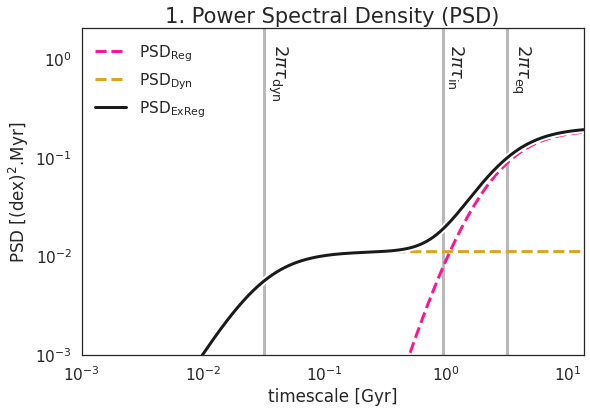

In [5]:
# 1. PSD:

def time2freq(t):
    return 1/t

#f = 10**np.arange(0,np.log10(cosmo.age(0.0).value*1e3),0.1)
t = np.arange(1.0,cosmo.age(0.0).value*1e3,1.0)
f = 1/t
tpi = 2*np.pi

fig, ax = plt.subplots(figsize=(9,6))

psd_full, psd_reg, psd_gmc = gp_sfh_kernels.extended_regulator_model_PSD(f, *psd_params)

gyrfac = 1e3

plt.plot(t/gyrfac, psd_reg, '--', lw=3,color='deeppink',label=r'PSD$_{\rm Reg}$')
plt.plot(t/gyrfac, psd_gmc, '--',lw=3,color='goldenrod',label=r'PSD$_{\rm Dyn}$')

plt.plot(t/gyrfac, psd_full,'w', lw=7)
plt.plot(t/gyrfac, psd_full,'k', lw=3,label=r'PSD$_{\rm ExReg}$')

llim = 1e-3

plt.ylim(llim,2e0)
plt.xlim(np.amin(t)/gyrfac,np.amax(t)/gyrfac)
plt.legend(edgecolor='w',loc=2)

plt.vlines(psd_params[1]*1e3*tpi/gyrfac, llim,plt.ylim()[1],'k',alpha=0.3,lw=3)
plt.vlines(psd_params[2]*1e3*tpi/gyrfac, llim,plt.ylim()[1],'k',alpha=0.3,lw=3)
plt.vlines(psd_params[4]*1e3*tpi/gyrfac, llim,plt.ylim()[1],'k',alpha=0.3,lw=3)
plt.text(psd_params[1]*1e3*tpi*1.05/gyrfac, plt.ylim()[1]/1.4,r'$2\pi\tau_{\rm eq}$',fontsize=18,rotation=270,va='top')
plt.text(psd_params[2]*1e3*tpi*1.05/gyrfac, plt.ylim()[1]/1.4,r'$2\pi\tau_{\rm in}$',fontsize=18,rotation=270,va='top')
plt.text(psd_params[4]*1e3*tpi*1.05/gyrfac, plt.ylim()[1]/1.4,r'$2\pi\tau_{\rm dyn}$',fontsize=18,rotation=270,va='top')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('timescale [Gyr]')
plt.ylabel('PSD [(dex)$^2$.Myr]')
plt.title('1. Power Spectral Density (PSD)',fontsize=21)

# secax = ax.secondary_xaxis('top', functions=(time2freq, time2freq))
# secax.set_xlabel('frequency [Myr$^{-1}$]')
plt.savefig('figures/fig1panel1.png',bbox_inches='tight')
plt.show()

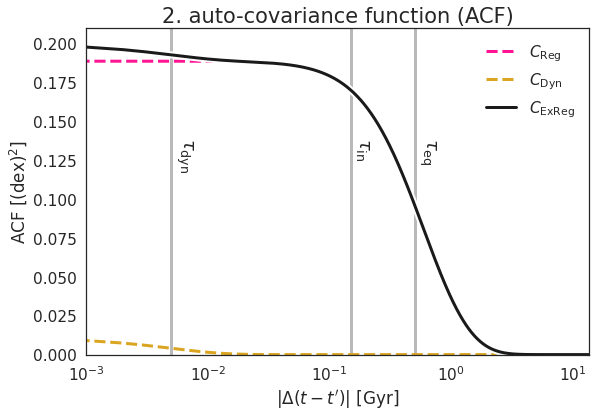

In [6]:
# 2. ACF

deltat = np.arange(0,(cosmo.age(0.0).value),0.001)
c_full, c_reg, c_gmc = gp_sfh_kernels.extended_regulator_model_kernel(deltat, *psd_params, base_e_to_10=True, return_components=True)

fig, ax = plt.subplots(figsize=(9,6))

plt.plot(deltat, c_reg, '--', lw=3,color='deeppink',label=r'$C_{\rm Reg}$')
plt.plot(deltat, c_gmc, '--',lw=3,color='goldenrod',label=r'$C_{\rm Dyn}$')

plt.plot(deltat, c_full,'w', lw=7)
plt.plot(deltat, c_full,'k', lw=3,label=r'$C_{\rm ExReg}$')

llim = 0

plt.ylim(0,)
plt.xlim(deltat[1],np.amax(deltat) )


plt.vlines(psd_params[1], llim,plt.ylim()[1],'k',alpha=0.3,lw=3)
plt.vlines(psd_params[2], llim,plt.ylim()[1],'k',alpha=0.3,lw=3)
plt.vlines(psd_params[4], llim,plt.ylim()[1],'k',alpha=0.3,lw=3)
plt.text(psd_params[1]*1.05, plt.ylim()[1]/1.5,r'$\tau_{\rm eq}$',fontsize=18,rotation=270,va='top')
plt.text(psd_params[2]*1.05, plt.ylim()[1]/1.5,r'$\tau_{\rm in}$',fontsize=18,rotation=270,va='top')
plt.text(psd_params[4]*1.05, plt.ylim()[1]/1.5,r'$\tau_{\rm dyn}$',fontsize=18,rotation=270,va='top')

plt.legend(edgecolor='w')
plt.xscale('log')
plt.xlabel('$|\Delta (t-t\')|$ [Gyr]')
plt.ylabel('ACF [(dex)$^2$]')

plt.title('2. auto-covariance function (ACF)',fontsize=21)
plt.savefig('figures/fig1panel2.png',bbox_inches='tight')
plt.show()

In [7]:
# 3. Draws from the GP

base_spec = []
nsamp = 10000
random_seed = 42
fname = 'precomputed_kernels/explanatory_figure_case1_withspec.pkl'

try:
    with open(fname, 'rb') as fil:
        case1 = pickle.load(fil)
        print('loaded precomputed kernel')
except:
    case1 = simple_GP_sfh(sp=sp, cosmo=cosmo)
    case1.zval = 0.0
    case1.get_tarr(n_tarr = len(deltat))
    #case1.get_basesfh(sfhtype='MS', mstar = 10.0)
    case1.get_basesfh(sfhtype='const')
    case1.kernel = gp_sfh_kernels.extended_regulator_model_kernel_paramlist

    case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, kernel_params = psd_params)
    case1.get_spec(nsamp)
    
    with open(fname, 'wb') as fil:
        pickle.dump(case1, fil)

loaded precomputed kernel


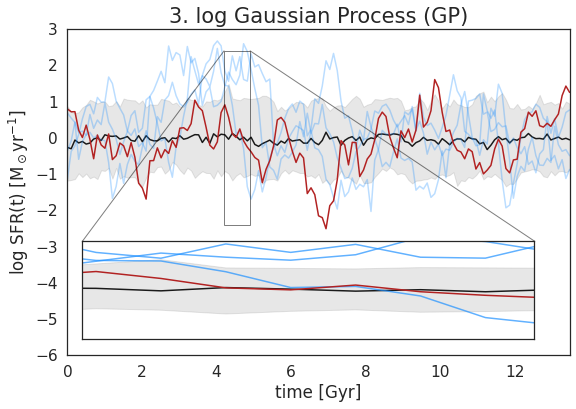

In [8]:
fig, ax = plt.subplots(figsize=(9,6))

sfh1color = 'firebrick'
sfh5color = 'dodgerblue'
sfhpercentilecolor = 'k'

example_gal = 30

plt.plot(case1.tarr, np.nanmedian(case1.samples.T,1),sfhpercentilecolor)
plt.fill_between(case1.tarr, np.nanpercentile(case1.samples.T,16,1),
                 np.nanpercentile(case1.samples.T,84,1),color=sfhpercentilecolor,alpha=0.1)

plt.plot(case1.tarr, case1.samples.T[0:,2:5],color=sfh5color,alpha=0.3)
plt.plot(case1.tarr, case1.samples.T[0:,example_gal],color=sfh1color)

scalefac = 2.0

plt.ylim(-3*scalefac,1.5*scalefac)
plt.xlim(0,np.amax(case1.tarr))
plt.xlabel('time [Gyr]')
plt.ylabel('log SFR(t) [M$_\odot$yr$^{-1}$]')
plt.title('3. log Gaussian Process (GP)',fontsize=21)

axins = ax.inset_axes([0.03, 0.05, 0.9, 0.3])
axins.plot(case1.tarr, np.nanmedian(case1.samples.T,1),sfhpercentilecolor)
axins.fill_between(case1.tarr, np.nanpercentile(case1.samples.T,16,1),
                 np.nanpercentile(case1.samples.T,84,1),color=sfhpercentilecolor,alpha=0.1)

axins.plot(case1.tarr, case1.samples.T[0:,2:5],color=sfh5color,alpha=0.7)
axins.plot(case1.tarr, case1.samples.T[0:,example_gal],color=sfh1color)
# sub region of the original image
x1, x2, y1, y2 = 4.2,4.9, -1.2*scalefac, 1.2*scalefac
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels('')
axins.set_yticklabels('')

ax.indicate_inset_zoom(axins, edgecolor="black")
plt.savefig('figures/fig1panel3.png',bbox_inches='tight')
plt.show()


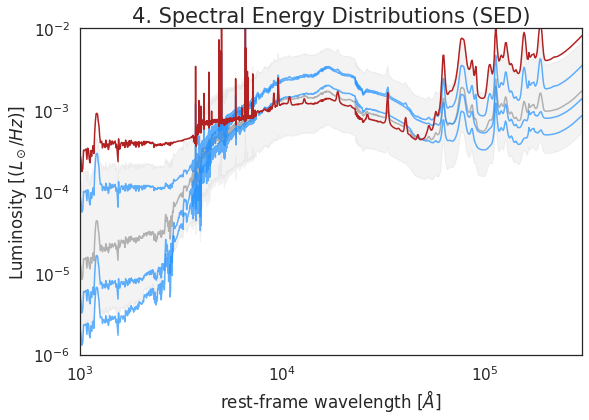

In [9]:
# 4. spectra

fig, ax = plt.subplots(figsize=(9,6))

plt.plot(case1.lam[0], np.nanmedian(np.array(case1.spec).T,1),color=sfhpercentilecolor,alpha=0.3)
plt.fill_between(case1.lam[0], 
                 np.nanpercentile(np.array(case1.spec).T,16,1),
                 np.nanpercentile(np.array(case1.spec).T,84,1),
                color=sfhpercentilecolor,alpha=0.05)

plt.plot(case1.lam[0], np.array(case1.spec[2:5]).T,color=sfh5color,alpha=0.7)

plt.plot(case1.lam[0], case1.spec[example_gal],color=sfh1color)

#plt.legend(edgecolor='w')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e3,3e5); 
# plt.ylim(2e-18,1e-14)
plt.ylim(1e-6,1e-2)
plt.xlabel('rest-frame wavelength [$\AA$]')
plt.ylabel('Luminosity [$(L_\odot/Hz)$]')
plt.title('4. Spectral Energy Distributions (SED)',fontsize=21)
plt.savefig('figures/fig1panel4.png',bbox_inches='tight')
plt.show()

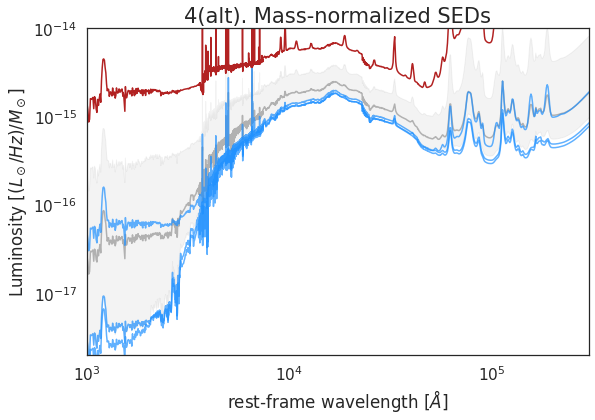

In [10]:
# 4. spectra

fig, ax = plt.subplots(figsize=(9,6))

plt.plot(case1.lam[0], np.nanmedian(np.array(case1.spec_massnorm).T,1),color=sfhpercentilecolor,alpha=0.3)
plt.fill_between(case1.lam[0], 
                 np.nanpercentile(np.array(case1.spec_massnorm).T,16,1),
                 np.nanpercentile(np.array(case1.spec_massnorm).T,84,1),
                color=sfhpercentilecolor,alpha=0.05)

plt.plot(case1.lam[0], np.array(case1.spec_massnorm[2:5]).T,color=sfh5color,alpha=0.7)

plt.plot(case1.lam[0], case1.spec_massnorm[example_gal],color=sfh1color)

#plt.legend(edgecolor='w')
plt.xscale('log'); plt.yscale('log')
plt.xlim(1e3,3e5); 
plt.ylim(2e-18,1e-14)
plt.xlabel('rest-frame wavelength [$\AA$]')
plt.ylabel('Luminosity [$(L_\odot/Hz)/M_\odot$]')
plt.title('4(alt). Mass-normalized SEDs',fontsize=21)
plt.savefig('figures/fig1panel4norm.png',bbox_inches='tight')
plt.show()

# Figure 2: Effects of varying kernel parameters

In [11]:
def makeplot(fig, axs, axins, case1, kernelcolor, labelval, **kernelargs):

    axs[0].plot(case1.tarr, case1.kernel(case1.tarr, **kernelargs),lw=3,color=kernelcolor,label=labelval,zorder=100)
    axs[0].set_xlabel('$|\Delta (t-t\')|$ [Gyr]')
    axs[0].set_ylabel('ACF [(dex)$^2$]')
    axs[0].set_xscale('log')
    axs[0].set_xlim(np.amin(case1.tarr),np.amax(case1.tarr))
    
    axs[1].plot(case1.tarr, case1.samples[0],color=kernelcolor)
    axs[1].set_xlim(0,np.amax(case1.tarr));
    axs[1].set_ylim(-4,3)
    axs[1].set_xlabel('time [Gyr]')
    axs[1].set_ylabel('log SFR(t) [M$_\odot$yr$^{-1}$]')
    
    axins.plot(case1.tarr, case1.samples[0],color=kernelcolor)
    # sub region of the original image
    x1, x2, y1, y2 = 2.5,3.0, -1.08,1.08
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels('')
    #axins.set_yticklabels('')
    axs[1].indicate_inset_zoom(axins, edgecolor="black")

100%|██████████| 1000/1000 [00:06<00:00, 161.07it/s]


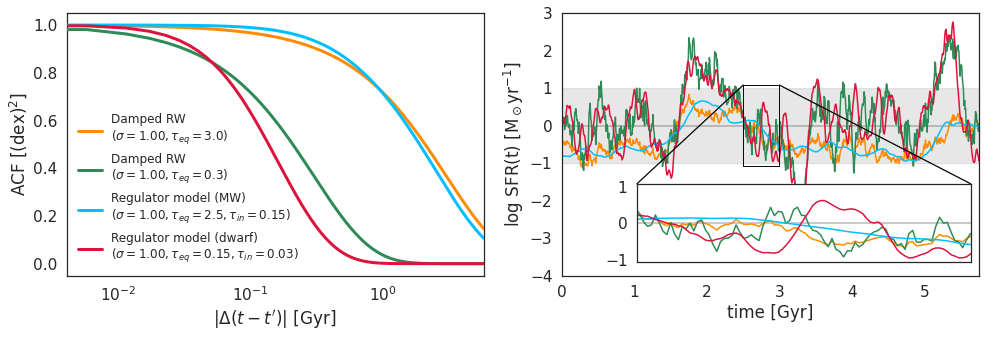

In [12]:
case1 = simple_GP_sfh(sp=sp, cosmo=cosmo)
case1.zval = 1.0
case1.get_tarr(n_tarr = 1000)
case1.get_basesfh(sfhtype='const')

nsamp = 1000
random_seed = 42

fig, axs = plt.subplots(1,2,figsize=(14,5))
axins = axs[1].inset_axes([0.18, 0.05, 0.8, 0.3])

axs[1].plot(case1.tarr, np.zeros_like(case1.tarr),'k',alpha=0.3)
axins.plot(case1.tarr, np.zeros_like(case1.tarr),'k',alpha=0.3)

axs[1].fill_between(case1.tarr, np.ones_like(case1.tarr),np.ones_like(case1.tarr)*(-1.),color='k',alpha=0.1)

#------------------------------------------------------

case1.kernel = gp_sfh_kernels.damped_random_walk_kernel
kernelstr = 1.0
case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, force_cov=True, 
                                    sigma=kernelstr, tau_eq=3.0)
makeplot(fig, axs, axins, case1, 'darkorange', 'Damped RW\n'+r'($\sigma=%.2f,\tau_{eq}=3.0$)' %kernelstr, 
                                     sigma=kernelstr, tau_eq=3.0)

kernelstr = 1.0
case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, force_cov=True, 
                                    sigma=kernelstr, tau_eq=0.3)
makeplot(fig, axs, axins, case1, 'seagreen', 'Damped RW\n'+r'($\sigma=%.2f,\tau_{eq}=0.3$)' %kernelstr, 
                                     sigma=kernelstr, tau_eq=0.3)

#------------------------------------------------------

case1.kernel = gp_sfh_kernels.regulator_model_kernel
kernelstr = 1.0
case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, force_cov=True, 
                                    sigma=kernelstr, tau_eq=2.5, tau_in = 0.15)
makeplot(fig, axs, axins, case1, 'deepskyblue', 
                                     'Regulator model (MW)\n'+r'($\sigma=%.2f,\tau_{eq}=2.5,\tau_{in}=0.15$)' %kernelstr, 
                                     sigma=kernelstr, tau_eq=2.5, tau_in = 0.15)

kernelstr = 1.0
case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, force_cov=True, 
                                    sigma=kernelstr, tau_eq=0.15, tau_in = 0.03)
makeplot(fig, axs, axins, case1, 'crimson', 
                                     'Regulator model (dwarf) \n'+r'($\sigma=%.2f,\tau_{eq}=0.15,\tau_{in}=0.03$)' %kernelstr, 
                                     sigma=kernelstr, tau_eq=0.15, tau_in = 0.03)

axs[0].legend(edgecolor='w',fontsize=12,loc=3,framealpha=0.1)
plt.tight_layout()
plt.savefig('figures/diffkernels_SFH_example.png',bbox_inches='tight')
plt.show()

# Figure 3,4,6,7,9,10,16,17 prep - precompute models

In [13]:
from gp_sfh_kernels import *

sig_reg = np.sqrt(0.97) * (0.4)
sig_dyn = np.sqrt(0.03) * (0.4)
kernel_params_MW_1dex = [sig_reg, 2500/1e3, 150/1e3, sig_dyn, 25/1e3]
kernel_params_dwarf_1dex = [sig_reg, 30/1e3, 150/1e3, sig_dyn, 10/1e3]
kernel_params_noon_1dex = [sig_reg, 200/1e3, 100/1e3, sig_dyn, 50/1e3]
kernel_params_highz_1dex = [sig_reg, 15/1e3, 16/1e3, sig_dyn, 6/1e3]
print('using $\sigma_{reg}: %.4f$, $\sigma_{dyn}: %.4f$. ' %(sig_reg, sig_dyn))

TCF20_scattervals = [0.17, 0.53, 0.24, 0.27]
regnorm = 0.4
kernel_params_MW_TCF20 = [sig_reg/regnorm * TCF20_scattervals[0], 2500/1e3, 150/1e3, sig_dyn/regnorm * TCF20_scattervals[0], 25/1e3]
kernel_params_dwarf_TCF20 = [sig_reg/regnorm * TCF20_scattervals[1], 30/1e3, 150/1e3, sig_dyn/regnorm * TCF20_scattervals[1], 10/1e3]
kernel_params_noon_TCF20 = [sig_reg/regnorm * TCF20_scattervals[2], 200/1e3, 100/1e3, sig_dyn/regnorm * TCF20_scattervals[2], 50/1e3]
kernel_params_highz_TCF20 = [sig_reg/regnorm * TCF20_scattervals[3], 15/1e3, 16/1e3, sig_dyn/regnorm * TCF20_scattervals[3], 6/1e3]

using $\sigma_{reg}: 0.3940$, $\sigma_{dyn}: 0.0693$. 


MW \sigma_eff = sqrt(C(\tau=0)): 0.4000000 dex
dwarf \sigma_eff = sqrt(C(\tau=0)): 0.4000000 dex
noon \sigma_eff = sqrt(C(\tau=0)): 0.4000000 dex
highz \sigma_eff = sqrt(C(\tau=0)): 0.4000000 dex


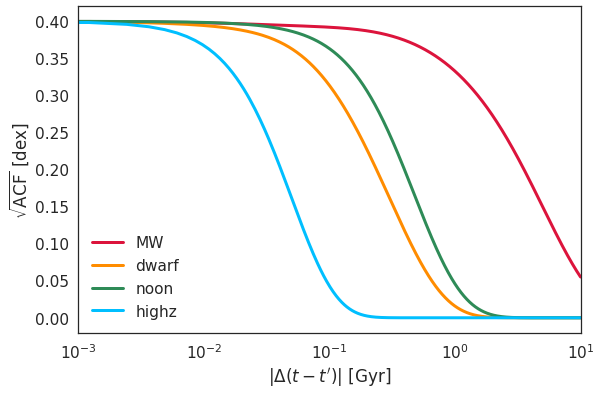

MW \sigma_eff = sqrt(C(\tau=0)): 0.1700 dex
dwarf \sigma_eff = sqrt(C(\tau=0)): 0.5300 dex
noon \sigma_eff = sqrt(C(\tau=0)): 0.2400 dex
highz \sigma_eff = sqrt(C(\tau=0)): 0.2700 dex


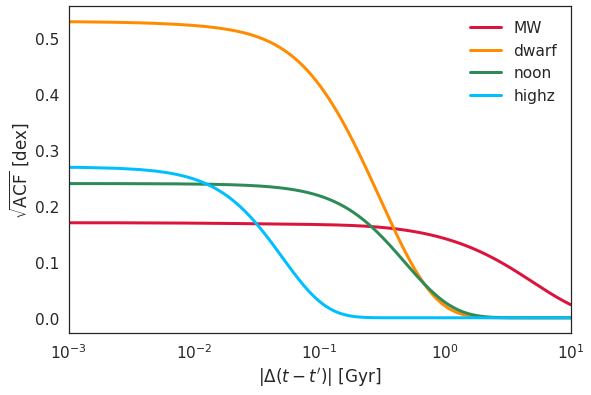

In [14]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

for i, case in enumerate(cases):

    deltat = np.linspace(0,cosmo.age(zval).value,tarr_res)
    temp = extended_regulator_model_kernel_paramlist(deltat, case_params[i])
    plt.plot(deltat, np.sqrt(temp),lw=3,label=case,color=case_colors[i])
    
    print(case+r' \sigma_eff = sqrt(C(\tau=0)): %.7f dex' %(np.sqrt(extended_regulator_model_kernel_paramlist(deltat, case_params[i])[0])))
    
plt.legend(edgecolor='w')
plt.xscale('log');
plt.xlim(1e-3,1e1)
plt.xlabel('$|\Delta (t-t\')|$ [Gyr]')
plt.ylabel(r'$\sqrt{\rm ACF}$ [dex]')
plt.show()
    
    
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_TCF20, kernel_params_dwarf_TCF20, kernel_params_noon_TCF20, kernel_params_highz_TCF20]


plt.figure(figsize=(9,6))

for i, case in enumerate(cases):
    
    deltat = np.linspace(0,cosmo.age(zval).value,tarr_res)
    temp = extended_regulator_model_kernel_paramlist(deltat, case_params[i])
    plt.plot(deltat, np.sqrt(temp),lw=3,label=case,color=case_colors[i])
   
    print(case+r' \sigma_eff = sqrt(C(\tau=0)): %.4f dex' %(np.sqrt(extended_regulator_model_kernel_paramlist(deltat, case_params[i])[0])))
    
plt.legend(edgecolor='w')
plt.xscale('log');
plt.xlim(1e-3,1e1)
plt.xlabel('$|\Delta (t-t\')|$ [Gyr]')
plt.ylabel(r'$\sqrt{\rm ACF}$ [dex]')
plt.show()

In [15]:
nsamp = 1000
tarr_res = 1000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]

for i, case in enumerate(cases):
    
    case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
    case1.get_tarr(n_tarr = tarr_res)
    #case1.get_basesfh(sfhtype='MS', mstar = 10.0)
    case1.get_basesfh(sfhtype='const')
    case1.kernel = extended_regulator_model_kernel_paramlist


    case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                        force_cov=True, kernel_params = case_params[i])
    
    case1.get_spec(nsamp = nsamp)
    case1.calc_spectral_features(massnorm = True)
    
    fname = work_dir + 'precomputed_kernels/v3_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.pkl' %(tarr_res, zval, nsamp, random_seed)
    with open(fname, 'wb') as fil:
        pickle.dump(case1, fil)

100%|██████████| 1000/1000 [00:09<00:00, 108.47it/s]


In [16]:
nsamp = 1000
tarr_res = 1000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_TCF20, kernel_params_dwarf_TCF20, kernel_params_noon_TCF20, kernel_params_highz_TCF20]

for i, case in enumerate(cases):
    
    case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
    case1.get_tarr(n_tarr = tarr_res)
    #case1.get_basesfh(sfhtype='MS', mstar = 10.0)
    case1.get_basesfh(sfhtype='const')
    case1.kernel = extended_regulator_model_kernel_paramlist


    case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                        force_cov=True, kernel_params = case_params[i])
    
    case1.get_spec(nsamp = nsamp)
    case1.calc_spectral_features(massnorm = True)
    
    fname = work_dir + 'precomputed_kernels/v3_ExReg_TCF20_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.pkl' %(tarr_res, zval, nsamp, random_seed)
    with open(fname, 'wb') as fil:
        pickle.dump(case1, fil)

100%|██████████| 1000/1000 [00:09<00:00, 108.84it/s]


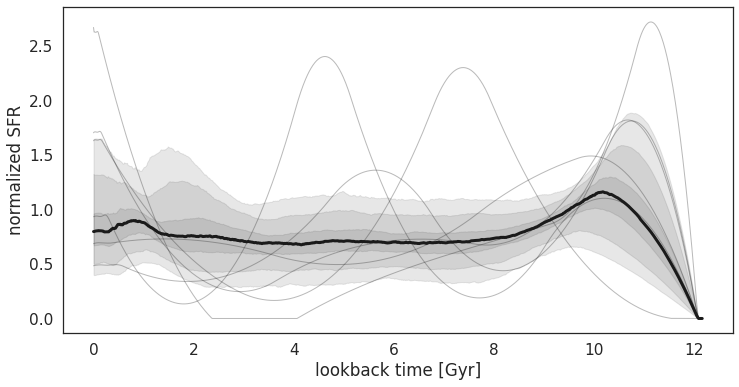

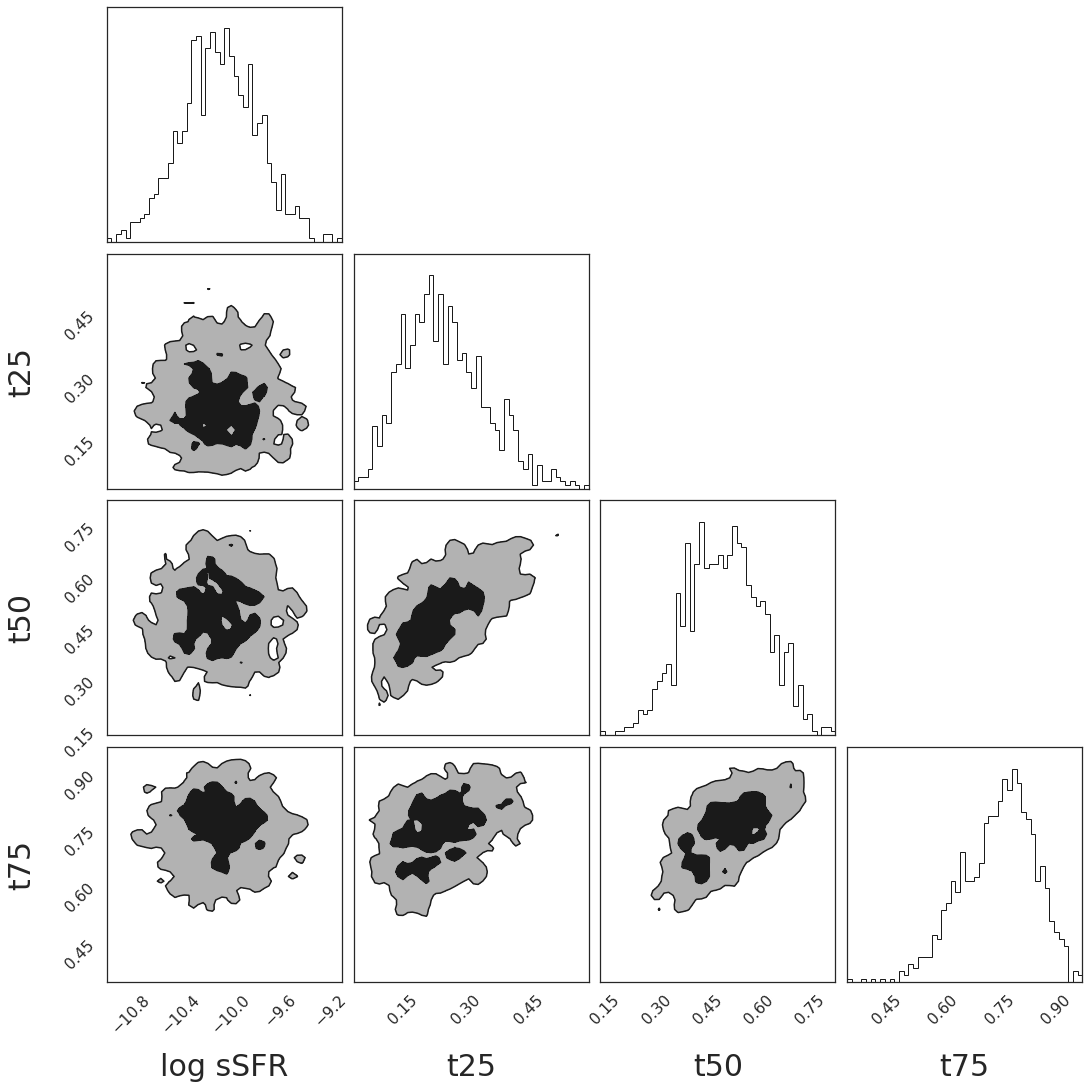

In [17]:
def normal_sfr():
#     return np.random.normal(scale=0.3)-0.77
    return np.random.normal(scale=0.3)-1.08
#     return np.random.normal(scale=0.3)-0.1

priors = db.Priors()
priors.Nparam = 3
#priors.sfr_prior_type = 'sSFRlognormal'
priors.sample_sfr_prior = normal_sfr
priors.mass_min = 9-1e-6
priors.mass_max = 9+1e-6
priors.sample_sfh_tuple()

#priors.plot_prior_distributions()

priors.plot_sfh_prior(numdraws=1000, zval=zval)

def get_spec_varsfh(self, nsamp, tarr_res = 100):

    bands = fsps.list_filters()
    filter_wavelengths = [fsps.filters.get_filter(bands[i]).lambda_eff for i in range(len(bands))]

    all_lam, all_spec, all_spec_massnorm, all_mstar, all_emline_wav, all_emline_lum, all_emline_lum_massnorm, all_filtmags, all_basesfhs = [], [], [], [], [], [], [], [], []

    for i in tqdm(range(nsamp)):
        
        temp_sfh, temp_time = db.tuple_to_sfh(priors.sample_sfh_tuple(), zval=zval, res = tarr_res)
        log_tempsfh = np.log10(temp_sfh)
        log_tempsfh[np.isnan(log_tempsfh)] = -3
        specsfh = 10**(log_tempsfh+self.samples[i, 0:])
        #specsfh = 10**(self.basesfh+self.samples[i, 0:])
        self.sp.set_tabular_sfh(self.tarr, specsfh)
        lam, spec = self.sp.get_spectrum(tage = self.t_univ)
        mstar = self.sp.stellar_mass
#         bandmags = self.sp.get_mags(tage = self.cosmo.age(self.zval).value, redshift = self.zval, bands = bands)

        all_lam.append(lam)
        all_spec.append(spec)
        all_spec_massnorm.append(spec/mstar)
        all_mstar.append(mstar)
        all_emline_wav.append(self.sp.emline_wavelengths)
        all_emline_lum.append(self.sp.emline_luminosity)
        all_emline_lum_massnorm.append(self.sp.emline_luminosity / mstar)
#         all_filtmags.append(bandmags)
        all_basesfhs.append(log_tempsfh)

    self.lam = all_lam
    self.spec = all_spec
    self.spec_massnorm = all_spec_massnorm
    self.mstar = all_mstar
    self.emline_wav = all_emline_wav
    self.emline_lum = all_emline_lum
    self.emline_lum_massnorm = all_emline_lum_massnorm
    self.basesfhs = all_basesfhs

    # not mass normalized
    self.bands = bands
    self.filter_wavelengths = filter_wavelengths
    self.filtmags = all_filtmags

    return

In [18]:
nsamp = 1000
tarr_res = 1000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_TCF20, kernel_params_dwarf_TCF20, kernel_params_noon_TCF20, kernel_params_highz_TCF20]

for i, case in enumerate(cases):
    
    case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
    case1.get_tarr(n_tarr = tarr_res)
    #case1.get_basesfh(sfhtype='MS', mstar = 10.0)
    case1.get_basesfh(sfhtype='dirichlet')
    case1.kernel = extended_regulator_model_kernel_paramlist


    case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                        force_cov=True, kernel_params = case_params[i])
#     case1.get_spec(nsamp = nsamp)
    get_spec_varsfh(case1, nsamp = nsamp, tarr_res = tarr_res)
    case1.calc_spectral_features(massnorm = True)
    
    fname = work_dir + 'precomputed_kernels/v3_ExReg_TCF20_'+case+'_varsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.pkl' %(tarr_res, zval, nsamp, random_seed)
    with open(fname, 'wb') as fil:
        pickle.dump(case1, fil)

unknown basesfh type. set yourself with len of tarr.


100%|██████████| 1000/1000 [01:26<00:00, 11.54it/s]


unknown basesfh type. set yourself with len of tarr.


100%|██████████| 1000/1000 [01:28<00:00, 11.36it/s]


unknown basesfh type. set yourself with len of tarr.


100%|██████████| 1000/1000 [01:28<00:00, 11.27it/s]


unknown basesfh type. set yourself with len of tarr.


100%|██████████| 1000/1000 [01:27<00:00, 11.39it/s]


# Figure 3,4,6,7,9,10,16,17 figures: kernels, SFHs and spectral features for different models (0.4 dex fixed, TFC20 scatter, variable base SFHs)

In [19]:
kernel_dir = work_dir + 'precomputed_kernels/'

In [20]:
nsamp = 1000
tarr_res = 1000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_names = ['MWA','Dwarf','Noon','High-z']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

casevals = []

cases = ['MW','dwarf','noon','highz']
for i, case in (list(enumerate(cases))):
    
    fname = kernel_dir + 'v3_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.pkl' %(tarr_res, zval, nsamp, random_seed)
    print('->',fname)
    with open(fname, 'rb') as fil:
        case1 = pickle.load(fil)
    casevals.append(case1)
    
    
# Compute the spectral medians
temps = []
temps_lo = []
temps_hi = []
for i in range(4):
    temps.append(np.nanmedian(np.log10(np.array(casevals[i].spec_massnorm)),0))
    temps_lo.append(np.nanpercentile(np.log10(np.array(casevals[i].spec_massnorm)),16,0))
    temps_hi.append(np.nanpercentile(np.log10(np.array(casevals[i].spec_massnorm)),84,0))    

-> /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_1dex_MW_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
-> /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_1dex_dwarf_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
-> /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_1dex_noon_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
-> /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_1dex_highz_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl


In [21]:
# reference spectrum
sp.set_tabular_sfh(case1.tarr, 10*np.ones_like(case1.tarr))
lam, spec = sp.get_spectrum(tage = case1.t_univ)
spec_normed = spec/sp.stellar_mass

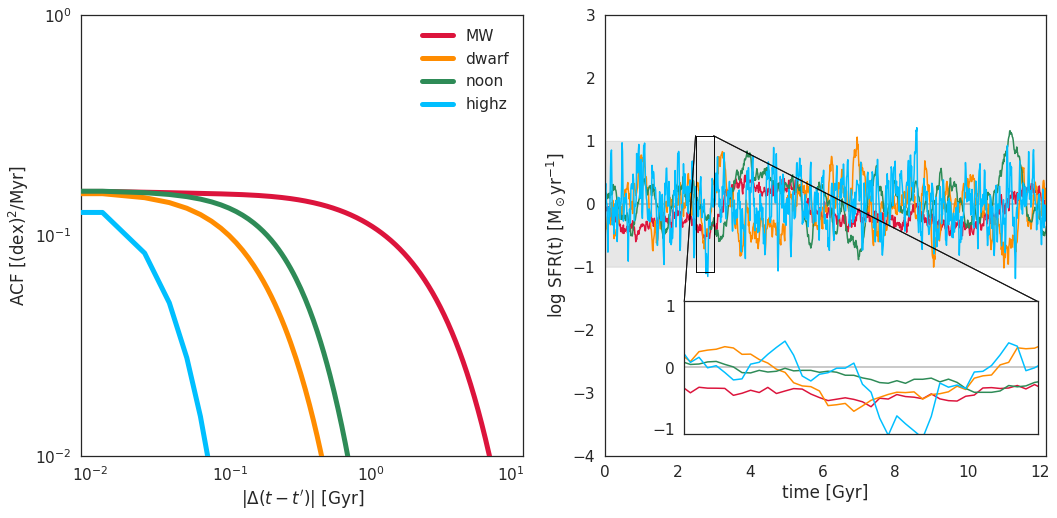

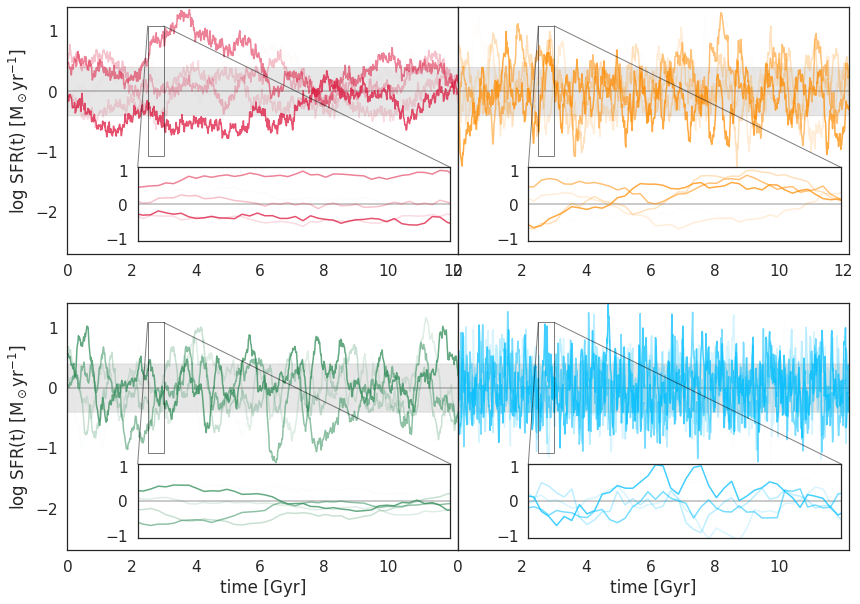

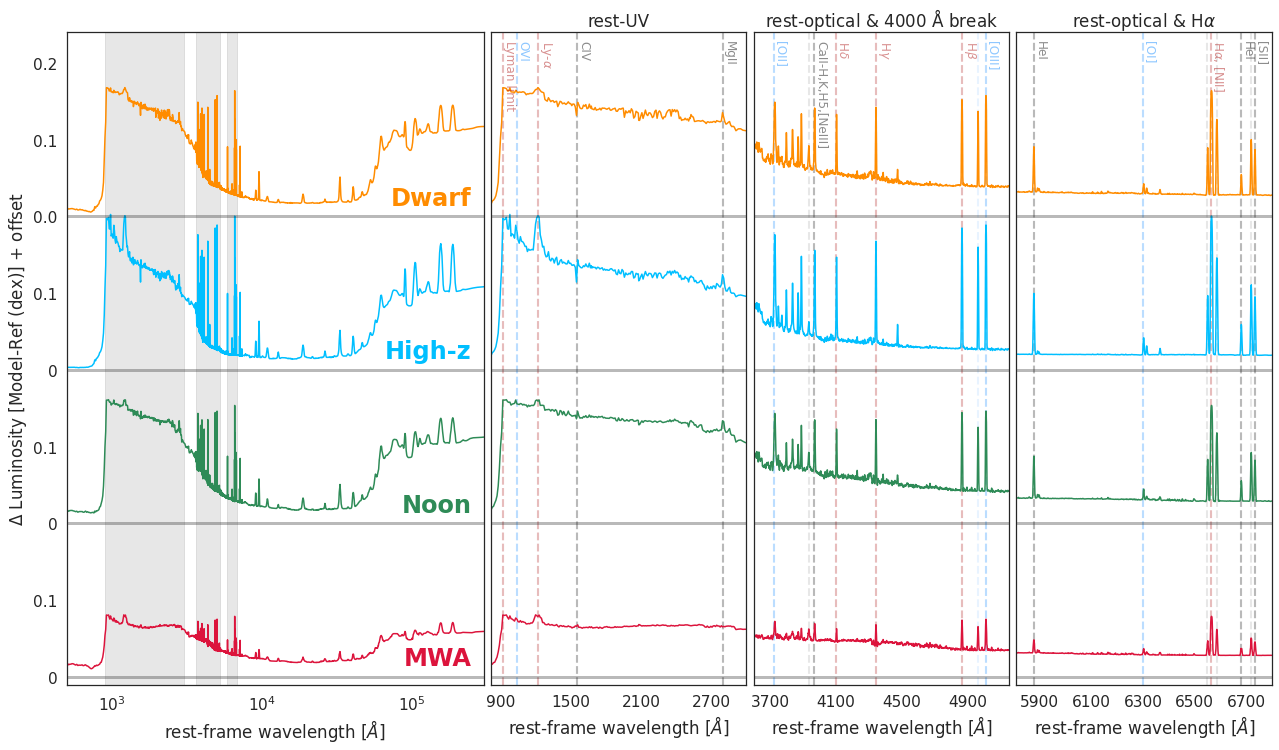

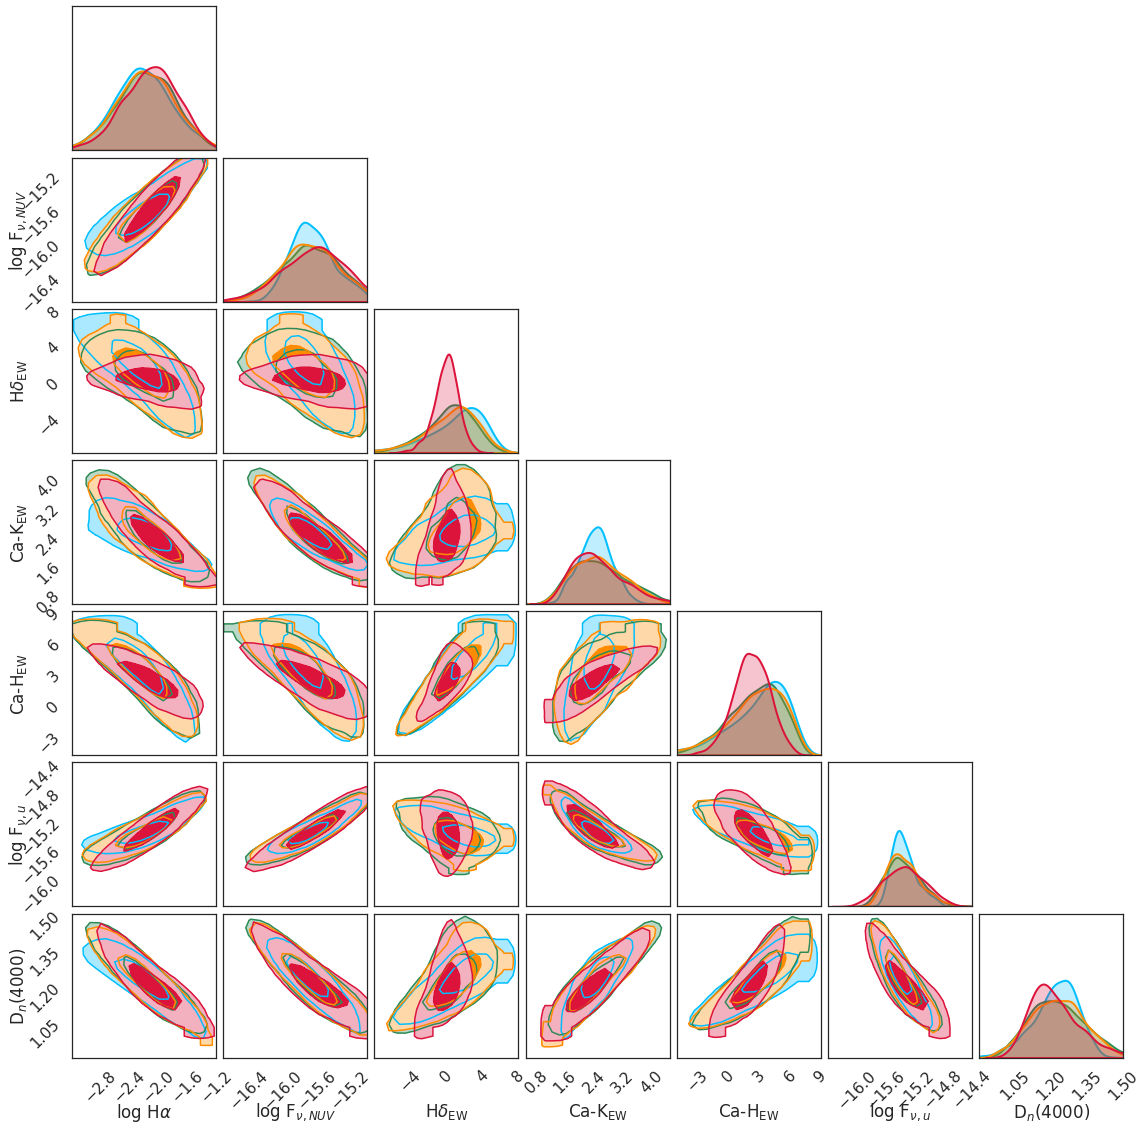

In [22]:
spectral_features_and_corner_plots.make_kernel_plot(casevals, cases, save_str='fixed')
spectral_features_and_corner_plots.make_sfh_draws_plot(casevals, cases, save_str='fixed')
spectral_features_and_corner_plots.make_spectral_features_fig(temps, casevals, cases, spec_normed, save_str='fixed',plt_offset=0.2,llim = -0.01, ulim = 4.2)
spectral_features_and_corner_plots.make_spectral_corner_plot(casevals, cases, save_str='fixed')

In [23]:
casevals = []

cases = ['MW','dwarf','noon','highz']
for i, case in (list(enumerate(cases))):
    
    fname = kernel_dir + 'v3_ExReg_TCF20_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.pkl' %(tarr_res, zval, nsamp, random_seed)
    print('->',fname)
    with open(fname, 'rb') as fil:
        case1 = pickle.load(fil)
    casevals.append(case1)
    
# Compute the spectral medians
temps = []
temps_lo = []
temps_hi = []
for i in range(4):
    temps.append(np.nanmedian(np.log10(np.array(casevals[i].spec_massnorm)),0))
    temps_lo.append(np.nanpercentile(np.log10(np.array(casevals[i].spec_massnorm)),16,0))
    temps_hi.append(np.nanpercentile(np.log10(np.array(casevals[i].spec_massnorm)),84,0))
    

-> /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_TCF20_MW_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
-> /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_TCF20_dwarf_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
-> /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_TCF20_noon_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
-> /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_TCF20_highz_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl


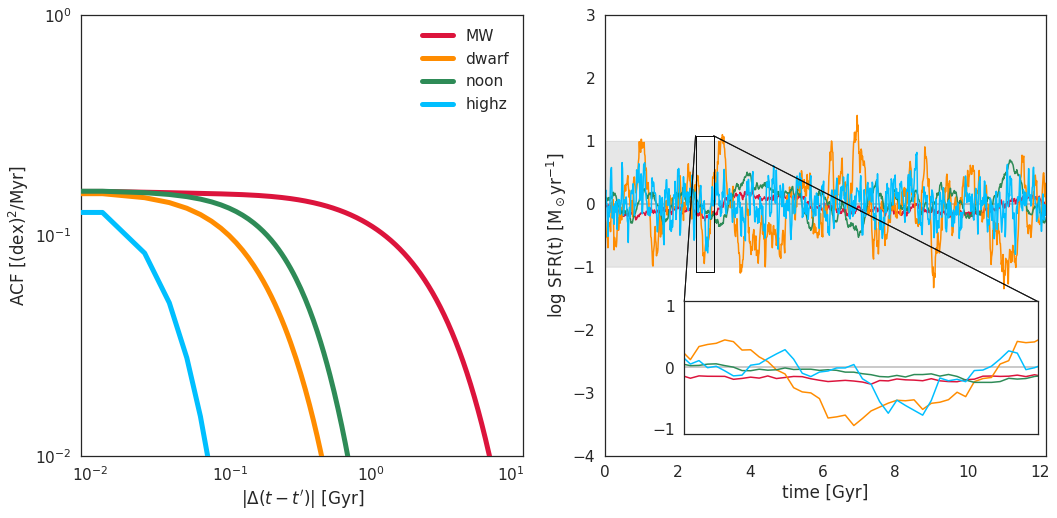

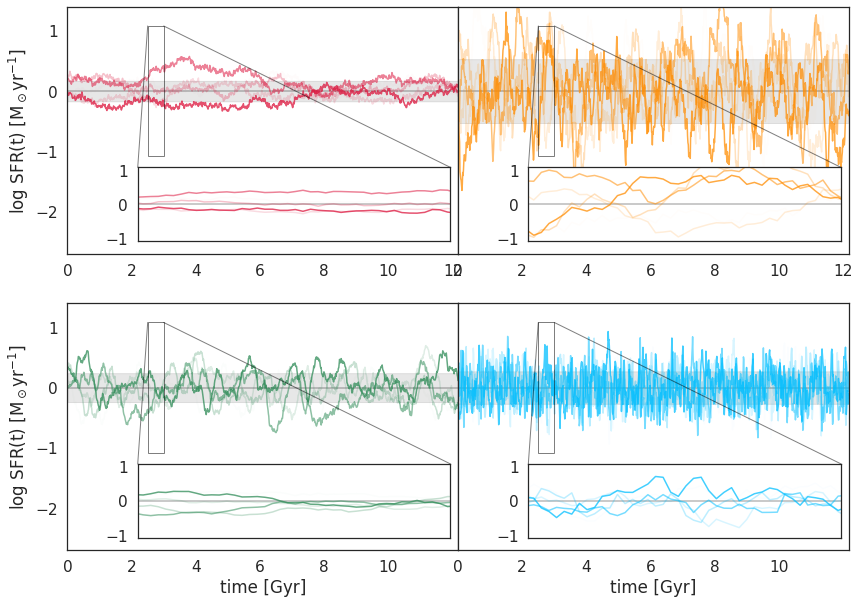

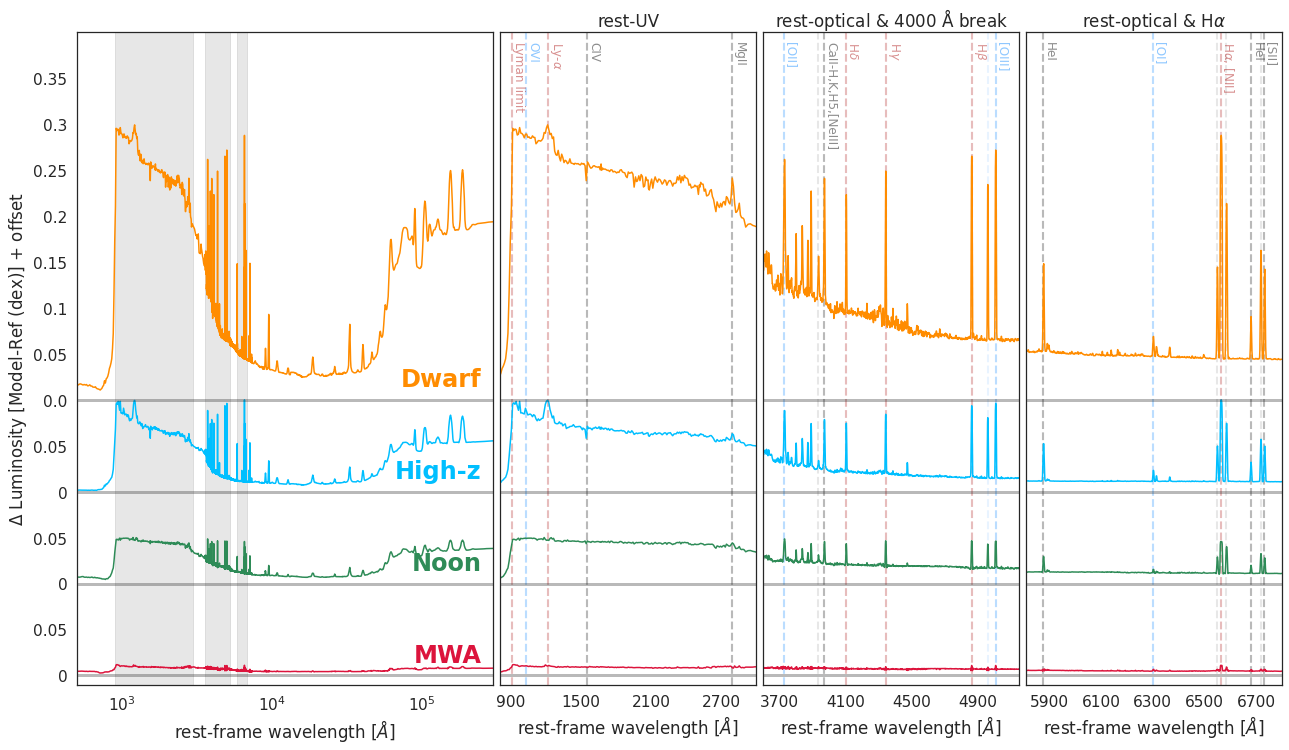

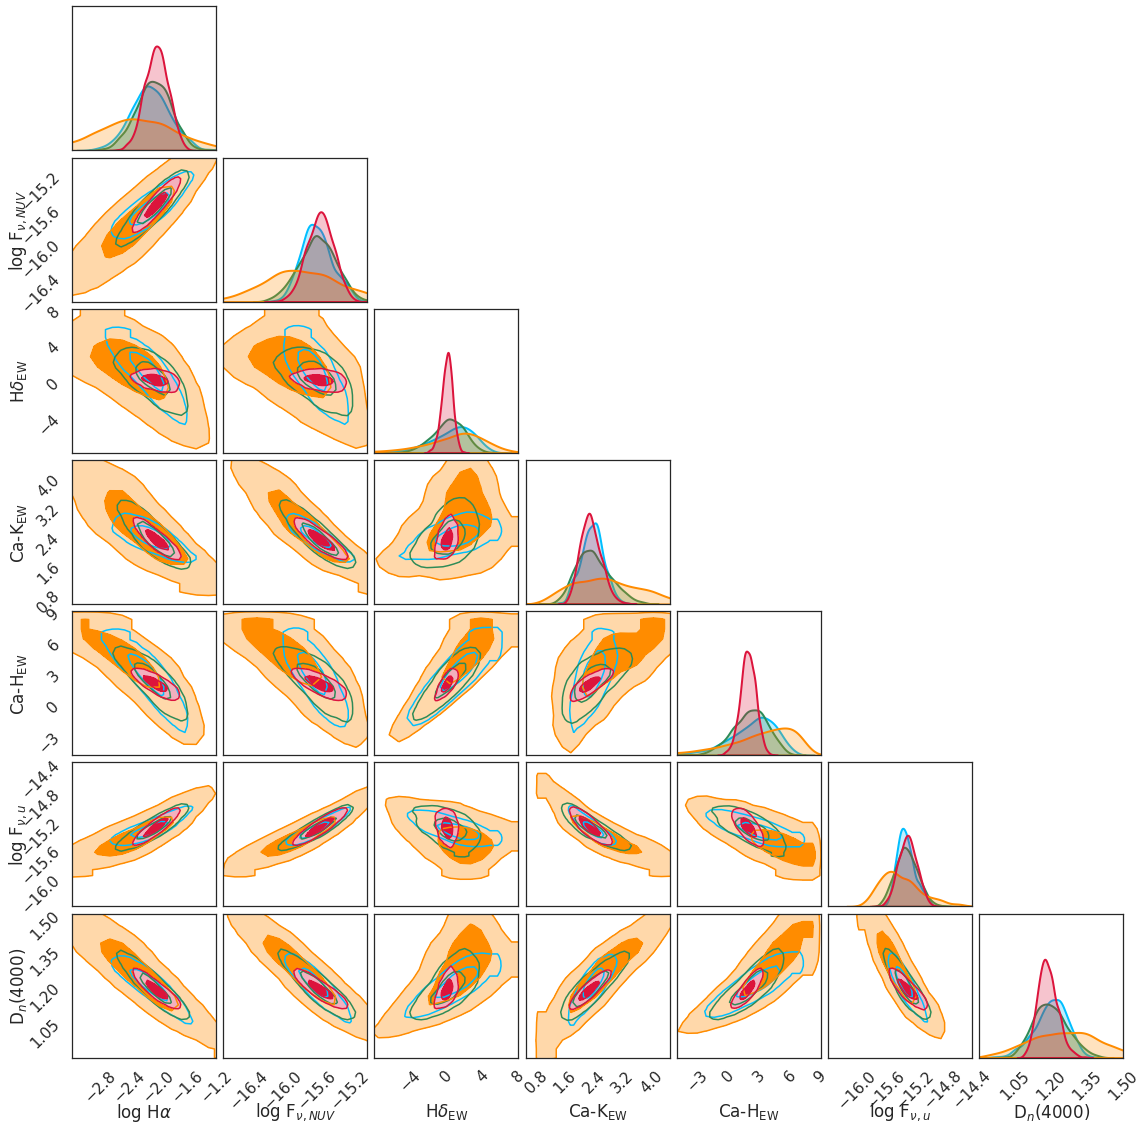

In [24]:
spectral_features_and_corner_plots.make_kernel_plot(casevals, cases, save_str='var')
spectral_features_and_corner_plots.make_sfh_draws_plot(casevals, cases, save_str='var')
spectral_features_and_corner_plots.make_spectral_features_fig(temps, casevals, cases, spec_normed, save_str='var',plt_offset=0.1,llim = -0.01, ulim = 7.0, line_y = 0.69)
spectral_features_and_corner_plots.make_spectral_corner_plot(casevals, cases, save_str='var')

In [25]:
casevals = []

cases = ['MW','dwarf','noon','highz']
# for i, case in reversed(list(enumerate(cases))):
for i, case in (list(enumerate(cases))):
    
    fname = kernel_dir + 'v3_ExReg_TCF20_'+case+'_varsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.pkl' %(tarr_res, zval, nsamp, random_seed)
    print('opening: ',fname)
    with open(fname, 'rb') as fil:
        case1 = pickle.load(fil)
    casevals.append(case1)
    
    
# Compute the spectral medians
temps = []
temps_lo = []
temps_hi = []
for i in range(4):
    temps.append(np.nanmedian(np.log10(np.array(casevals[i].spec_massnorm)),0))
    temps_lo.append(np.nanpercentile(np.log10(np.array(casevals[i].spec_massnorm)),16,0))
    temps_hi.append(np.nanpercentile(np.log10(np.array(casevals[i].spec_massnorm)),84,0))
    

opening:  /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_TCF20_MW_varsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
opening:  /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_TCF20_dwarf_varsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
opening:  /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_TCF20_noon_varsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
opening:  /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_TCF20_highz_varsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl


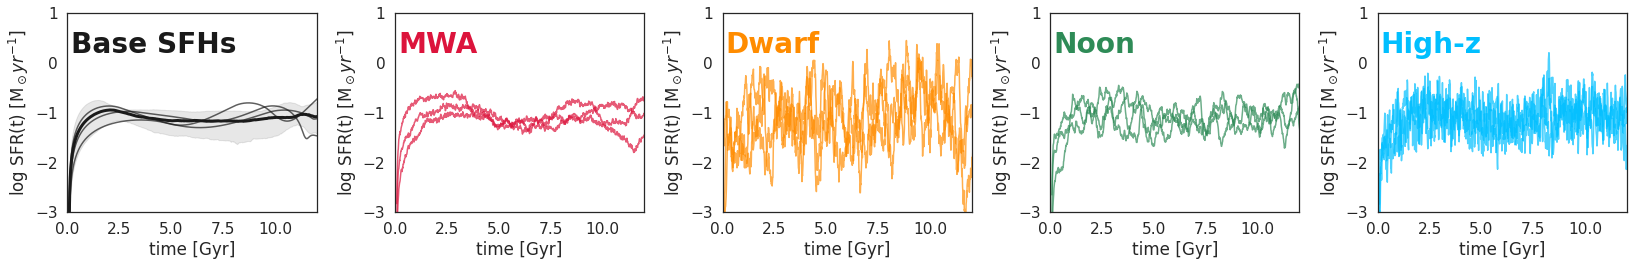

In [26]:
cases = ['MW','dwarf','noon','highz']
case_names = ['MWA','Dwarf','Noon','High-z']
case_params = [kernel_params_MW_TCF20, kernel_params_dwarf_TCF20, kernel_params_noon_TCF20, kernel_params_highz_TCF20]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(23,4))

starttime = 0
endtime = 12

case1 = casevals[0]

plt.subplot(1,5,1)
plt.plot(case1.tarr, np.nanmedian(np.array(case1.basesfhs),0),'k-',lw=3)
plt.fill_between(case1.tarr, np.nanpercentile(np.array(case1.basesfhs),16,0),
                np.nanpercentile(np.array(case1.basesfhs),84,0),color='k',alpha=0.1)
for si in range(6,9):
    plt.plot(case1.tarr, case1.basesfhs[si], color='k',alpha=0.7)
plt.ylim(-3,1.0)
plt.xlim(starttime, endtime)
plt.xlabel('time [Gyr]')
plt.ylabel('log SFR(t) [M$_\odot yr^{-1}$]')
plt.text(starttime+0.15, 0.2, 'Base SFHs',fontsize=28, fontweight='bold',color='k')

for i, case in enumerate(cases):
    
#     fname = 'precomputed_kernels/varsfh_'+case+'.h5'
#     case1 = hickle.load(fname)
    case1 = casevals[i]
    
    plt.subplot(1,5,i+2)
    for si in range(6,9):
        #plt.plot(case1.tarr, case1.basesfhs[si], color='k',alpha=0.3)
        plt.plot(case1.tarr, case1.basesfhs[si] + case1.samples[si,0:], color=case_colors[i],alpha=0.7)
    plt.ylim(-3,1.0)
    plt.xlim(starttime, endtime)
    plt.xlabel('time [Gyr]')
    plt.ylabel('log SFR(t) [M$_\odot yr^{-1}$]')
    plt.text(starttime+0.15, 0.2, case_names[i],fontsize=28, fontweight='bold',color=case_colors[i])
    
    #plt.yscale('log');plt.ylim(1e-2,)
#     plt.hist(np.log10(case1.mstar),histtype='step',lw=3,label=case,color=case_colors[i])
    
#     print(np.mean(np.log10(case1.mstar)))
#     plt.axvline(9.7 + np.pi/np.e*TCF20_scattervals[i]**2,lw=3,color=case_colors[i],linestyle='--')

#plt.legend(edgecolor='w')
#plt.xscale('log');

#plt.ylim(1e-3,1e1)
#plt.xlabel('log stellar mass')
#plt.ylabel('# galaxies')

plt.tight_layout()
plt.savefig('figures/var_basesfh_examples.png',bbox_inches='tight')
plt.show()
    

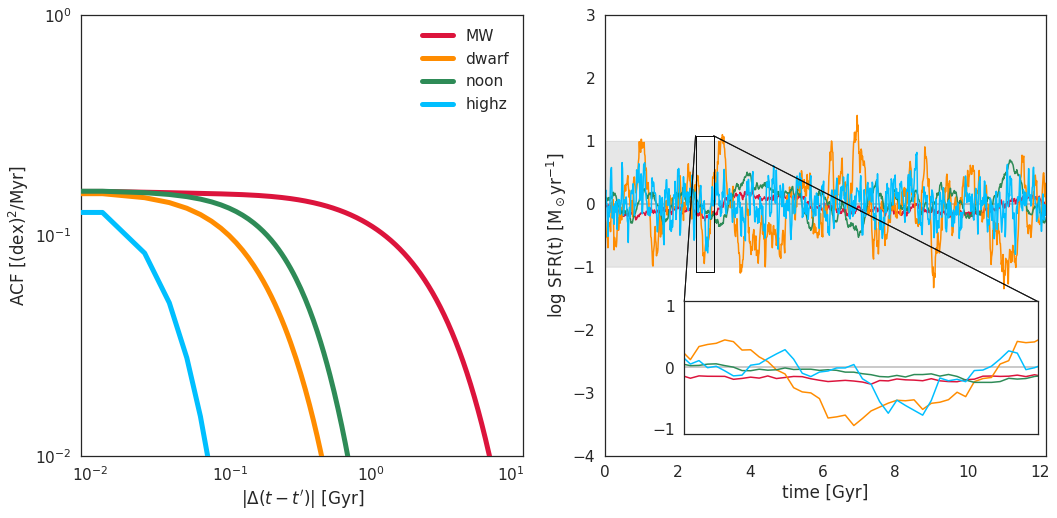

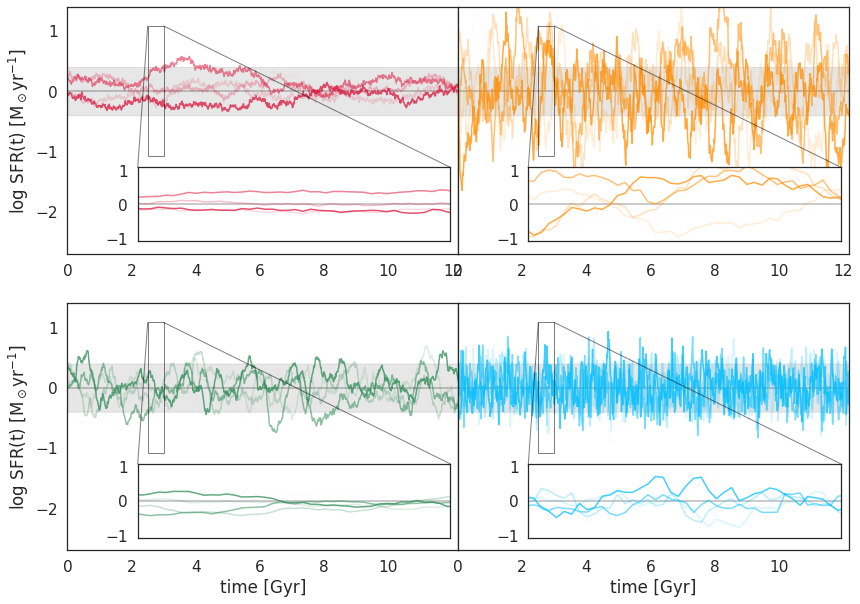

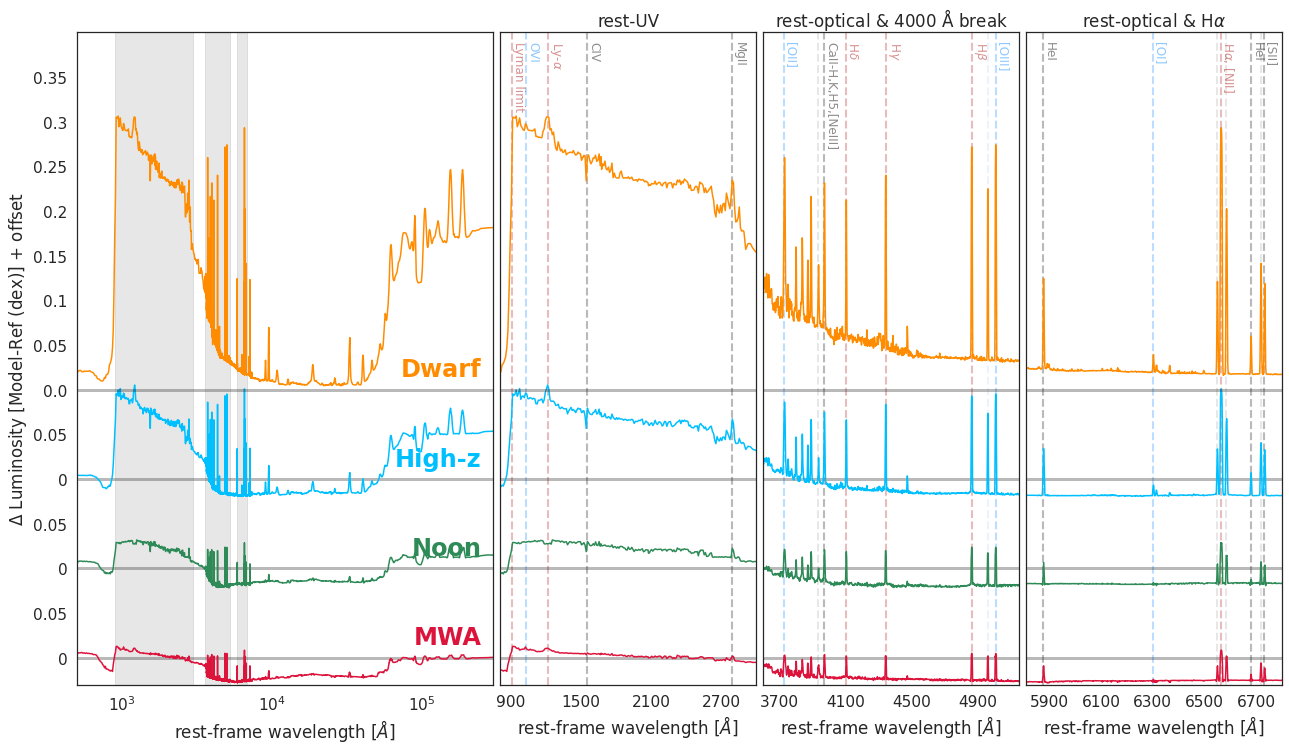

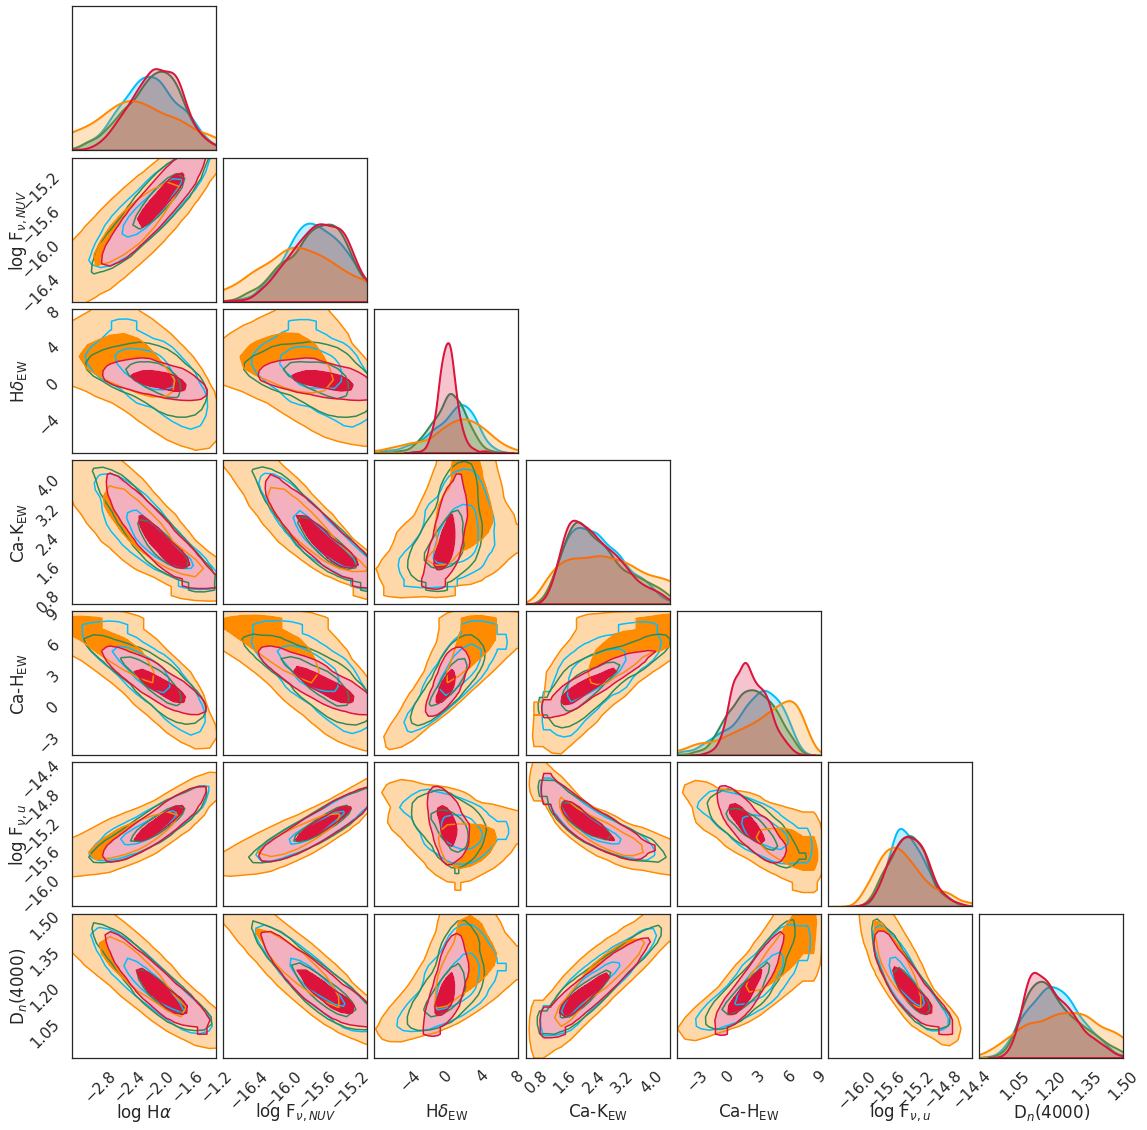

In [27]:
spectral_features_and_corner_plots.make_kernel_plot(casevals, cases, save_str='varsfh')
spectral_features_and_corner_plots.make_sfh_draws_plot(casevals, cases, save_str='varsfh')
spectral_features_and_corner_plots.make_spectral_features_fig(temps, casevals, cases, spec_normed, save_str='varsfh',plt_offset=0.1,llim = -0.03, ulim = 7.0, line_y = 0.69)
spectral_features_and_corner_plots.make_spectral_corner_plot(casevals, cases, save_str='varsfh')

# Figure 5: Effects of varying kernel parameters on spectral features

In [28]:
# fiducial model:

psd_params = [1.0, 500/1e3, 150/1e3, 0.1, 10/1e3]

# and variations 

psd_var_sigma = 10**np.linspace(-0.5,0.5,10)
psd_var_sigma_gmc = 10**np.linspace(-2.0,0.0,10)
psd_var_tau_eq = 10**np.linspace(1.0,4.0,10)
psd_var_tau_in = 10**np.linspace(1.0,3.0,10)
psd_var_tau_gmc = 10**np.linspace(0.0,2.0,10)

# compare fiducial model to parameter space midpoint
psd_var_sigma[5], psd_var_sigma_gmc[5], psd_var_tau_in[5], psd_var_tau_eq[5], psd_var_tau_gmc[5]

(1.1364636663857248,
 0.1291549665014884,
 129.1549665014884,
 464.15888336127773,
 12.91549665014884)

In [29]:
def analyze_model_deviations(varparam, varlabel, varindex, nsamp = 1000, tarr_res = 1000, zval = 0.1, random_seed = 42):

    cases = []

    for i, param in enumerate(varparam):

        case_params = psd_params.copy()
        case_params[varindex] = param

        case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
        case1.get_tarr(n_tarr = tarr_res)
        #case1.get_basesfh(sfhtype='MS', mstar = 10.0)
        case1.get_basesfh(sfhtype='const')
        case1.kernel = extended_regulator_model_kernel_paramlist


        case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                            force_cov=True, kernel_params = case_params)

        case1.get_spec(nsamp = nsamp, calc_bands=False)
        case1.calc_spectral_features(massnorm = True)

        cases.append(deepcopy(case1))

    #------------------------------------------------------------------    

    dn4k_mean, dn4k_16, dn4k_84 = [], [], []
    ha_mean, ha_16, ha_84 = [], [], []
    hd_mean, hd_16, hd_84 = [], [], []
    mstar_mean, mstar_16, mstar_84 = [], [], []
    sfr_mean, sfr_16, sfr_84 = [], [], []

    for i, param in enumerate(psd_var_tau_eq):

        dn4k_mean.append(np.mean(cases[i].dn4000_vals))
        dn4k_16.append(np.percentile(cases[i].dn4000_vals,16))    
        dn4k_84.append(np.percentile(cases[i].dn4000_vals,84))    

        tempha = np.array(np.log10(cases[i].ha_lums).copy())
        ha_mean.append(np.mean(tempha))
        ha_16.append(np.percentile(tempha,16))    
        ha_84.append(np.percentile(tempha,84))    

        temphd = np.array(cases[i].hdelta_ews.copy())
        hd_mean.append(np.mean(temphd))
        hd_16.append(np.percentile(temphd,16))    
        hd_84.append(np.percentile(temphd,84))    

        mstar_mean.append(np.mean(np.log10(cases[i].mstar)))
        mstar_16.append(np.percentile(np.log10(cases[i].mstar),16))    
        mstar_84.append(np.percentile(np.log10(cases[i].mstar),84))    

        sfr_mean.append(np.mean(np.array(cases[i].samples)[0:,0]))
        sfr_16.append(np.percentile(np.array(cases[i].samples)[0:,0],16))    
        sfr_84.append(np.percentile(np.array(cases[i].samples)[0:,0],84))    

    #------------------------------------------------------------------

    fig, ax = plt.subplots(1,5,figsize=(21,4))

    plt.subplot(1,5,1)
    plt.plot(varparam, mstar_mean,'-',lw=3)
    plt.fill_between(varparam, mstar_16, mstar_84,alpha=0.3)
    plt.xscale('log')
    plt.xlabel(varlabel);plt.ylabel('log Stellar Mass [M$_\odot$]')

    plt.subplot(1,5,2)
    plt.plot(varparam, sfr_mean,'-',lw=3)
    plt.fill_between(varparam, sfr_16, sfr_84,alpha=0.3)
    plt.xscale('log')
    plt.xlabel(varlabel);plt.ylabel('log SFR [M$_\odot$/yr]')

    plt.subplot(1,5,3)
    plt.plot(varparam, ha_mean,'-',lw=3)
    plt.fill_between(varparam, ha_16, ha_84,alpha=0.3)
    plt.xscale('log')
    plt.xlabel(varlabel);plt.ylabel(r'log H$\alpha$ [L$_\odot$]')

    plt.subplot(1,5,4)
    plt.plot(varparam, hd_mean,'-',lw=3)
    plt.fill_between(varparam, hd_16, hd_84,alpha=0.3)
    plt.xscale('log')
    plt.xlabel(varlabel);plt.ylabel(r'H$\delta_{\rm EW}$ [$\AA$]')

    plt.subplot(1,5,5)
    plt.plot(varparam, dn4k_mean,'-',lw=3)
    plt.fill_between(varparam, dn4k_16, dn4k_84,alpha=0.3)
    plt.xscale('log')
    plt.xlabel(varlabel);plt.ylabel('D$_n$(4000)')
    #plt.axvline(psd_params[1],color='k',alpha=0.7, linestyle='--')
    plt.tight_layout()
    plt.show()
    
    return cases

100%|██████████| 1000/1000 [00:08<00:00, 111.41it/s]


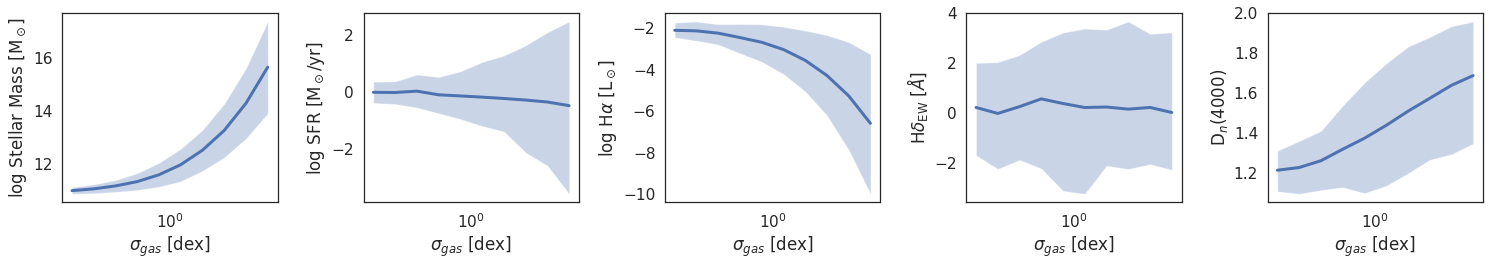

100%|██████████| 1000/1000 [00:08<00:00, 112.80it/s]


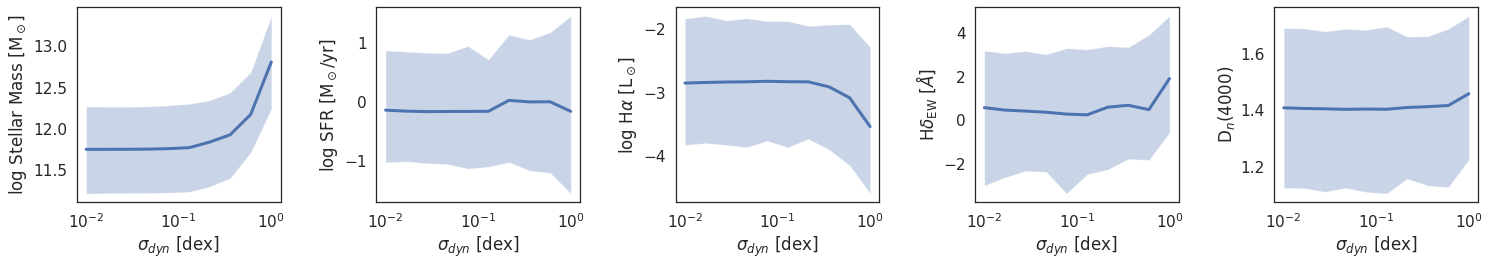

100%|██████████| 1000/1000 [00:08<00:00, 114.69it/s]


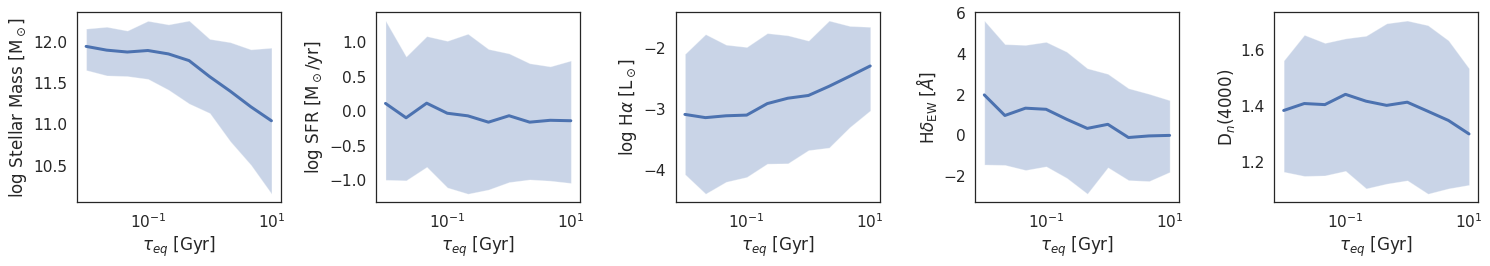

100%|██████████| 1000/1000 [00:08<00:00, 113.22it/s]


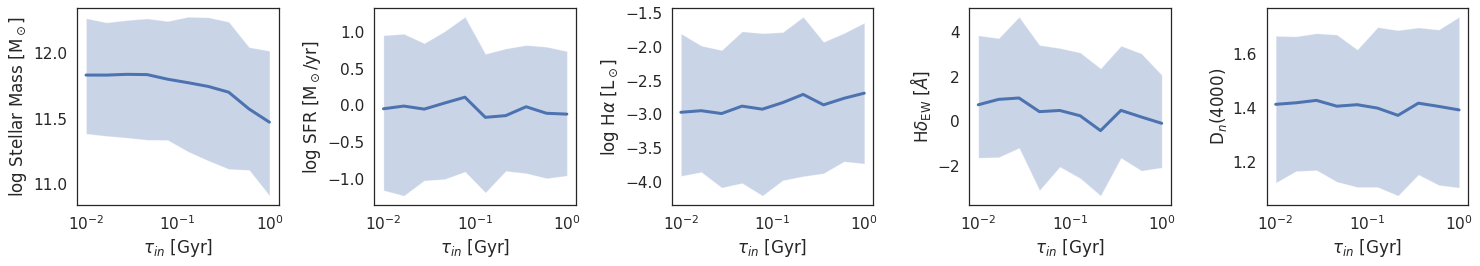

100%|██████████| 1000/1000 [00:08<00:00, 116.33it/s]


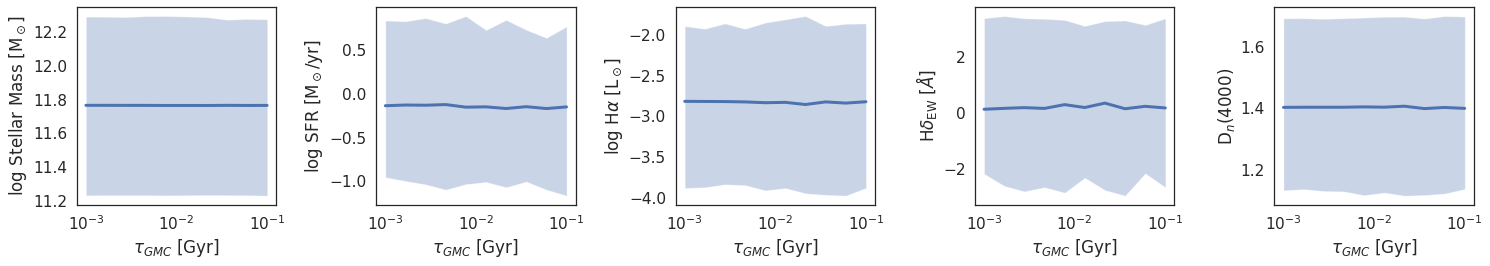

In [30]:
cases_sigma = analyze_model_deviations(varparam = psd_var_sigma, 
                                           varlabel = r'$\sigma_{gas}$ [dex]', 
                                           varindex = 0, nsamp=100)

cases_sigma_gmc = analyze_model_deviations(varparam = psd_var_sigma_gmc, 
                                           varlabel = r'$\sigma_{dyn}$ [dex]', 
                                           varindex = 3, nsamp=100)

cases_tau_eq = analyze_model_deviations(varparam = psd_var_tau_eq/1e3, 
                                           varlabel = r'$\tau_{eq}$ [Gyr]', 
                                           varindex = 1, nsamp=100)

cases_tau_in = analyze_model_deviations(varparam = psd_var_tau_in/1e3, 
                                           varlabel = r'$\tau_{in}$ [Gyr]', 
                                           varindex = 2, nsamp=100)

cases_tau_gmc = analyze_model_deviations(varparam = psd_var_tau_gmc/1e3, 
                                           varlabel = r'$\tau_{GMC}$ [Gyr]', 
                                           varindex = 4, nsamp=100)

In [31]:
tarr_res = 1000
zval = 0.1
random_seed = 42
nsamp=1000

case_fid = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
case_fid.get_tarr(n_tarr = tarr_res)
#case1.get_basesfh(sfhtype='MS', mstar = 10.0)
case_fid.get_basesfh(sfhtype='const')
case_fid.kernel = extended_regulator_model_kernel_paramlist


case_fid.samples = case_fid.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                    force_cov=True, kernel_params = psd_params)

case_fid.get_spec(nsamp = nsamp, calc_bands=False)
case_fid_specfeatures = case_fid.calc_spectral_features(massnorm = True)

100%|██████████| 1000/1000 [00:08<00:00, 117.98it/s]


In [32]:
def make_var_param_figures(fid_qty, all_qtys, param_qtys, xlabel='log Stellar Mass [M$_\odot$]', llim = 10, ulim = 14, y_offset = 0.05, ygp = 0.63, figsize = (6,12), save_fname='test_specfeatures_varying', plot_yticks=True, nofig = False):
    
    yticks = []
    yticklabels = []

    qty_names = [r'$\tau_{\rm dyn}$',r'$\tau_{\rm in}$',r'$\tau_{\rm eq}$',r'$\sigma_{\rm dyn}$',r'$\sigma_{\rm gas}$']
    med_fid = np.nanmedian(fid_qty)


    if nofig == False:
        fig = plt.figure(figsize=figsize)
        sns.histplot(fid_qty,kde=True,lw=3)
        tempy = plt.ylim()

    else:
        sns.histplot(fid_qty,kde=True,lw=3)
        tempy = plt.ylim()

    
    for i in range(5):
        plt.fill_between([llim, ulim], 
                         [(i+1.5)*ygp*tempy[1],(i+1.5)*ygp*tempy[1]], 
                         [(i+2.35)*ygp*tempy[1],(i+2.35)*ygp*tempy[1]],
                         color='k',alpha=0.05,hatch='//')
        plt.text(llim+(ulim-llim)*0.03, (i+2.1)*ygp*tempy[1],qty_names[i],fontsize=24,fontweight='bold')

    colors = [matplotlib.cm.autumn(np.linspace(0, 1, len(all_qtys[0]))),
              matplotlib.cm.cool(np.linspace(0, 1, len(all_qtys[1]))),
              matplotlib.cm.copper(np.linspace(0, 1, len(all_qtys[2]))),
              matplotlib.cm.magma_r(np.linspace(0, 1, len(all_qtys[3]))),
              matplotlib.cm.viridis(np.linspace(0, 1, len(all_qtys[4])))]
    
    #-----------------------------------------
    
    for off_iter in range(len(qty_names)):
        
        y_grp_offset = ygp*tempy[1]*off_iter
        
        for i in range(len(all_qtys[off_iter])):
            plt.plot([med_fid,np.nanmedian(all_qtys[off_iter][i])], 
                     [y_grp_offset + tempy[1]*(1.0+i*y_offset), y_grp_offset + tempy[1]*(1.0+i*y_offset)],
                     lw=5, color=colors[off_iter][i])

            mid = np.nanmedian(all_qtys[off_iter][i])
            hi = np.nanpercentile(all_qtys[off_iter][i],84)-mid
            lo = mid-np.nanpercentile(all_qtys[off_iter][i],16)

            plt.errorbar(mid, y_grp_offset + tempy[1]*(1.0+i*y_offset),
                         xerr=np.array([lo,hi]).reshape(-1,1),
                         marker='o',markersize=6,lw=0,elinewidth=2,capsize=5,color=colors[off_iter][i],alpha=0.3)

            if (i==0) or (i == (len(cases_sigma)-1)):
                yticks.append(y_grp_offset + tempy[1]*(1.0+i*y_offset))
                yticklabels.append(np.round(param_qtys[off_iter][i],2))

    plt.ylabel(''); 
    plt.xlabel(xlabel)
    plt.xlim(llim, ulim)
    if plot_yticks == True:
        plt.yticks(yticks, yticklabels)
    else:
        plt.yticks([])
        
    if nofig == False:
        plt.savefig('figures/'+save_fname+'.png',bbox_inches='tight')
        plt.show()
    else:
        print('added qty')
        return

In [33]:
import matplotlib

added qty
added qty
added qty
added qty
added qty
added qty
added qty
added qty


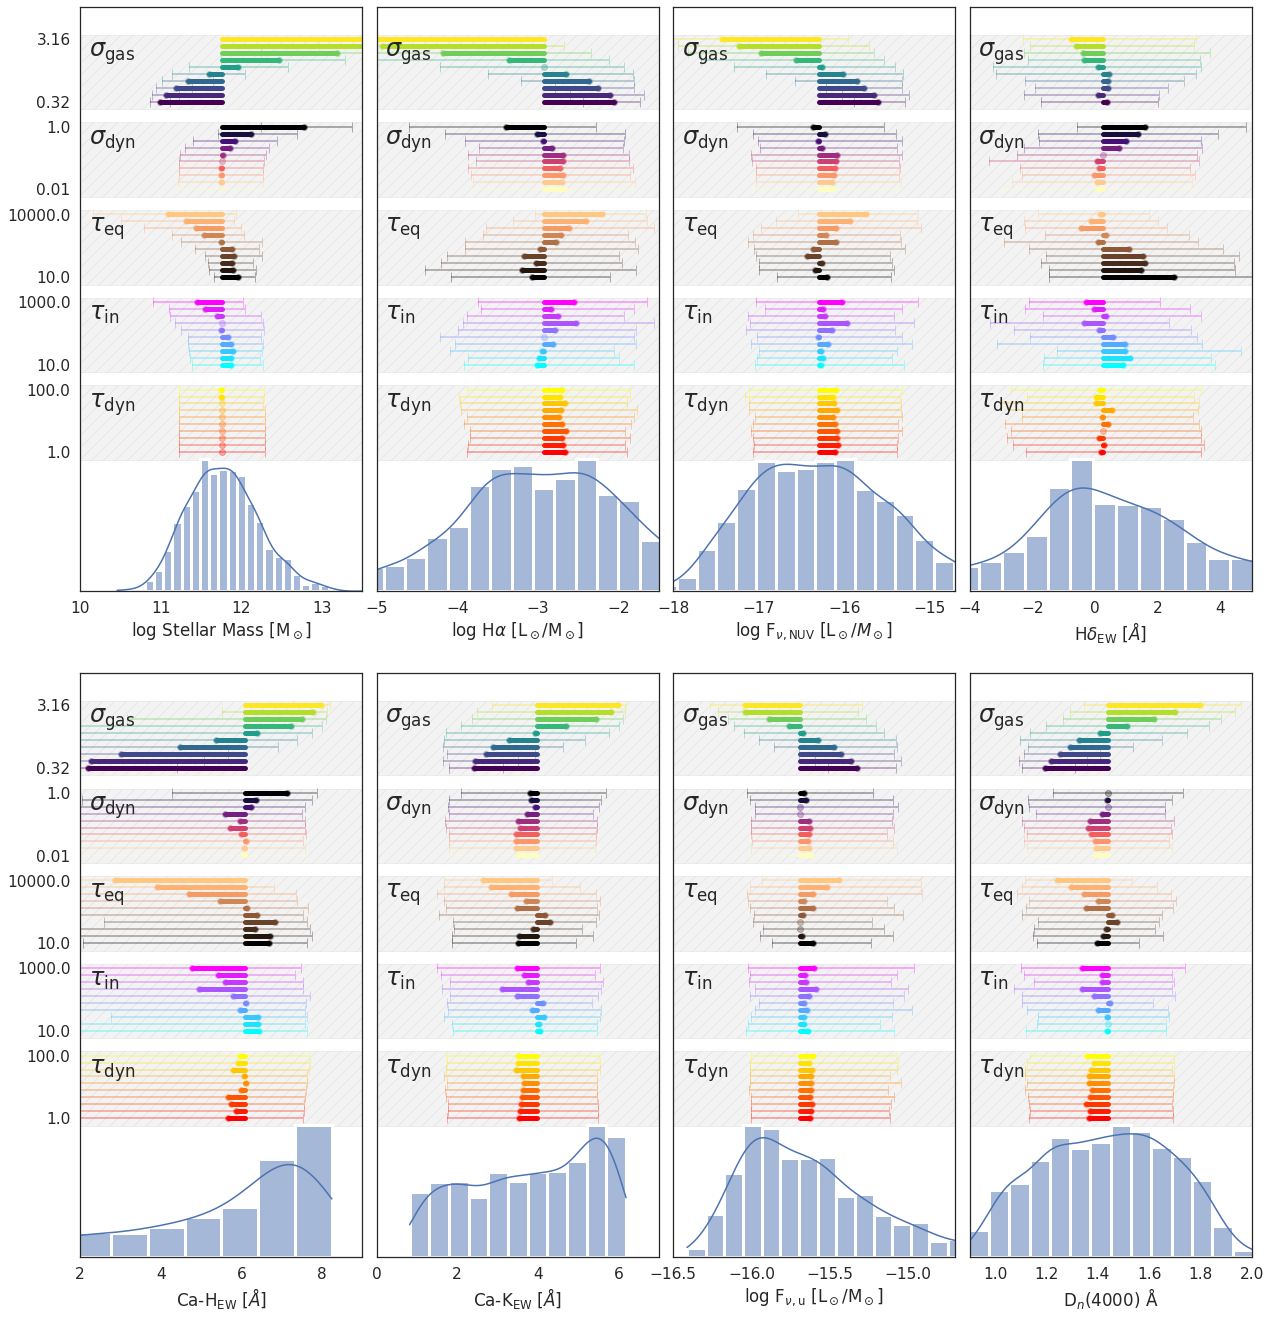

In [34]:
def make_large_variation_figure(figsize = (21,23)):
    
    fig = plt.subplots(2,4,figsize=figsize)
    plt.subplots_adjust(wspace=0.05, hspace = 0.14)
    
    plt.subplot(2,4,1)
    
    fid_qty = (np.log10(case_fid.mstar))
    all_qtys = []
    all_qtys.append([np.log10(cases_tau_gmc[i].mstar) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_tau_in[i].mstar) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_tau_eq[i].mstar) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_sigma_gmc[i].mstar) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_sigma[i].mstar) for i in range(len(cases_sigma))])

    param_qtys = [psd_var_tau_gmc, psd_var_tau_in, psd_var_tau_eq, psd_var_sigma_gmc, psd_var_sigma]

    make_var_param_figures(fid_qty, all_qtys, param_qtys, llim = 10, ulim = 13.5,save_fname='varparam_mass', nofig=True)
    
    plt.subplot(2,4,2)
    
    fid_qty = (np.log10(case_fid.ha_lums))
    all_qtys = []
    all_qtys.append([np.log10(cases_tau_gmc[i].ha_lums) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_tau_in[i].ha_lums) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_tau_eq[i].ha_lums) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_sigma_gmc[i].ha_lums) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_sigma[i].ha_lums) for i in range(len(cases_sigma))])

    param_qtys = [psd_var_tau_gmc, psd_var_tau_in, psd_var_tau_eq, psd_var_sigma_gmc, psd_var_sigma]

    make_var_param_figures(fid_qty, all_qtys, param_qtys, 
                           llim = -5., ulim = -1.5, xlabel=r'log H$\alpha$ [L$_\odot$/M$_\odot$]',
                           save_fname='varparam_ha',plot_yticks=False, nofig=True)
    
    plt.subplot(2,4,3)
    
    fid_qty = (np.log10(case_fid.nuv_vals))
    all_qtys = []
    all_qtys.append([np.log10(cases_tau_gmc[i].nuv_vals) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_tau_in[i].nuv_vals) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_tau_eq[i].nuv_vals) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_sigma_gmc[i].nuv_vals) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_sigma[i].nuv_vals) for i in range(len(cases_sigma))])

    param_qtys = [psd_var_tau_gmc, psd_var_tau_in, psd_var_tau_eq, psd_var_sigma_gmc, psd_var_sigma]

    make_var_param_figures(fid_qty, all_qtys, param_qtys, 
                           llim = -18, ulim = -14.7, xlabel=r'log F$_{\nu, {\rm NUV}}$ [L$_\odot/M_\odot$]',
                            save_fname='varparam_nuv',plot_yticks=False, nofig=True)
    
    plt.subplot(2,4,4)
    
    fid_qty = ((case_fid.hdelta_ews))
    all_qtys = []
    all_qtys.append([(cases_tau_gmc[i].hdelta_ews) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_tau_in[i].hdelta_ews) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_tau_eq[i].hdelta_ews) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_sigma_gmc[i].hdelta_ews) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_sigma[i].hdelta_ews) for i in range(len(cases_sigma))])

    param_qtys = [psd_var_tau_gmc, psd_var_tau_in, psd_var_tau_eq, psd_var_sigma_gmc, psd_var_sigma]

    make_var_param_figures(fid_qty, all_qtys, param_qtys, 
                           llim = -4., ulim = 5.0, xlabel=r'H$\delta_{\rm EW}$ [$\AA$]',
                           save_fname='varparam_hdelta',plot_yticks=False, nofig=True)
    
    plt.subplot(2,4,5)
    
    fid_qty = ((case_fid.caH_ews))
    all_qtys = []
    all_qtys.append([(cases_tau_gmc[i].caH_ews) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_tau_in[i].caH_ews) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_tau_eq[i].caH_ews) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_sigma_gmc[i].caH_ews) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_sigma[i].caH_ews) for i in range(len(cases_sigma))])

    param_qtys = [psd_var_tau_gmc, psd_var_tau_in, psd_var_tau_eq, psd_var_sigma_gmc, psd_var_sigma]

    make_var_param_figures(fid_qty, all_qtys, param_qtys, 
                           llim = 2., ulim = 9.0, xlabel=r'Ca-H$_{\rm EW}$ [$\AA$]',
                           save_fname='varparam_cah',plot_yticks=True, nofig = True)
    
    plt.subplot(2,4,6)
    
    fid_qty = ((case_fid.caK_ews))
    all_qtys = []
    all_qtys.append([(cases_tau_gmc[i].caK_ews) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_tau_in[i].caK_ews) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_tau_eq[i].caK_ews) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_sigma_gmc[i].caK_ews) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_sigma[i].caK_ews) for i in range(len(cases_sigma))])

    param_qtys = [psd_var_tau_gmc, psd_var_tau_in, psd_var_tau_eq, psd_var_sigma_gmc, psd_var_sigma]

    make_var_param_figures(fid_qty, all_qtys, param_qtys, 
                           llim = 0., ulim = 7.0, xlabel=r'Ca-K$_{\rm EW}$ [$\AA$]',
                           save_fname='varparam_cak',plot_yticks=False, nofig = True)
    
    plt.subplot(2,4,7)
    
    fid_qty = (np.log10(case_fid.u_vals))
    all_qtys = []
    all_qtys.append([np.log10(cases_tau_gmc[i].u_vals) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_tau_in[i].u_vals) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_tau_eq[i].u_vals) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_sigma_gmc[i].u_vals) for i in range(len(cases_sigma))])
    all_qtys.append([np.log10(cases_sigma[i].u_vals) for i in range(len(cases_sigma))])

    param_qtys = [psd_var_tau_gmc, psd_var_tau_in, psd_var_tau_eq, psd_var_sigma_gmc, psd_var_sigma]

    make_var_param_figures(fid_qty, all_qtys, param_qtys, 
                           llim = -16.5, ulim = -14.7, xlabel=r'log F$_{\nu, {\rm u}}$ [L$_\odot/$M$_\odot$]',
                           save_fname='varparam_u',plot_yticks=False, nofig = True)
    
    plt.subplot(2,4,8)
    
    fid_qty = ((case_fid.dn4000_vals))
    all_qtys = []
    all_qtys.append([(cases_tau_gmc[i].dn4000_vals) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_tau_in[i].dn4000_vals) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_tau_eq[i].dn4000_vals) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_sigma_gmc[i].dn4000_vals) for i in range(len(cases_sigma))])
    all_qtys.append([(cases_sigma[i].dn4000_vals) for i in range(len(cases_sigma))])

    param_qtys = [psd_var_tau_gmc, psd_var_tau_in, psd_var_tau_eq, psd_var_sigma_gmc, psd_var_sigma]

    make_var_param_figures(fid_qty, all_qtys, param_qtys, llim = 0.9, ulim = 2.0, xlabel=r'D$_n$(4000) ${\rm \AA}$',
                           save_fname='varparam_dn4000',plot_yticks=False, nofig = True)
    
    plt.savefig('figures/varparam_all.png',bbox_inches='tight')
    
make_large_variation_figure()

# Figure 8 and 13: Colors and color-selected post-starburst SFHs

In [35]:
nsamp = 1000
tarr_res = 1000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_names = ['MWA','Dwarf','Noon','High-z']
case_params = [kernel_params_MW_TCF20, kernel_params_dwarf_TCF20, kernel_params_noon_TCF20, kernel_params_highz_TCF20]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

# casevals = []
uvj_colors = []
nuvrk_colors = []
fuvvw3_colors = []

cases = ['MW','dwarf','noon','highz']
for i, case in (list(enumerate(cases))):
    
    fname = kernel_dir + 'v3_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.pkl' %(tarr_res, zval, nsamp, random_seed)
    print('opening: ',fname)
    with open(fname, 'rb') as fil:
        case1 = pickle.load(fil)
    
    band1 = 'u'
    band2 = 'v'
    band3 = '2mass_j'
    color1 = np.array(case1.filtmags)[0:, case1.bands.index(band1)] - np.array(case1.filtmags)[0:, case1.bands.index(band2)]
    color2 = np.array(case1.filtmags)[0:, case1.bands.index(band2)] - np.array(case1.filtmags)[0:, case1.bands.index(band3)]
    
    color_data = np.vstack([color2,color1]).T
    uvj_colors.append(color_data)
    
    band1 = 'galex_nuv'
    band2 = 'sdss_r'
    band3 = '2mass_ks'
    color1 = np.array(case1.filtmags)[0:, case1.bands.index(band1)] - np.array(case1.filtmags)[0:, case1.bands.index(band2)]
    color2 = np.array(case1.filtmags)[0:, case1.bands.index(band2)] - np.array(case1.filtmags)[0:, case1.bands.index(band3)]
    
    color_data = np.vstack([color2,color1]).T
    nuvrk_colors.append(color_data)
    
    band1 = 'galex_fuv'
    band2 = 'v'
    band3 = 'wise_w3'
    color1 = np.array(case1.filtmags)[0:, case1.bands.index(band1)] - np.array(case1.filtmags)[0:, case1.bands.index(band2)]
    color2 = np.array(case1.filtmags)[0:, case1.bands.index(band2)] - np.array(case1.filtmags)[0:, case1.bands.index(band3)]
    
    color_data = np.vstack([color2,color1]).T
    fuvvw3_colors.append(color_data)

opening:  /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_1dex_MW_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
opening:  /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_1dex_dwarf_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
opening:  /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_1dex_noon_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
opening:  /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_1dex_highz_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl


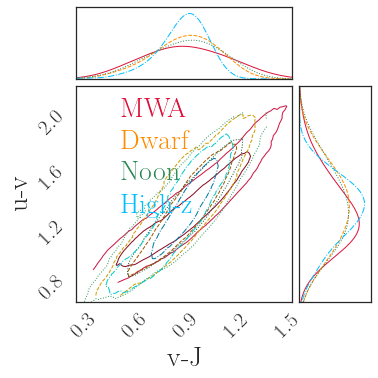

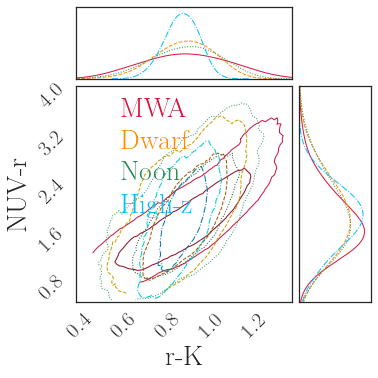

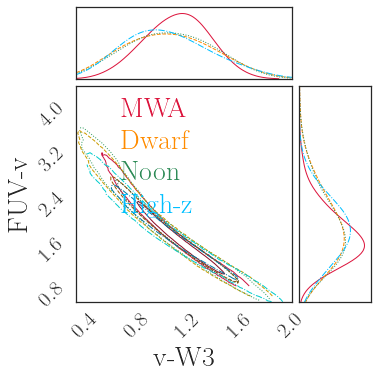

In [36]:
case_colors_hex = ['#DC143C', '#FF8C00', '#2E8B57', '#00BFFF']
case_ls = ['-','--',':','-.']

c = ChainConsumer()
for i in range(4):
    c.add_chain(uvj_colors[i], linestyle=case_ls[i], parameters = ['v-J','u-v'], name=case_names[i], color=case_colors_hex[i])
c.configure(kde=True, label_font_size=28, tick_font_size=21, legend_location=(1,0), legend_kwargs={'loc':2})
fig = c.plotter.plot(filename="figures/uvjplot.png", figsize="column")
fig.set_size_inches(3 + fig.get_size_inches())
plt.tight_layout()
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.savefig('figures/uvjplot.png', bbox_to_inches='tight')
plt.show()

c = ChainConsumer()
for i in range(4):
    c.add_chain(nuvrk_colors[i], linestyle=case_ls[i], parameters = ['r-K','NUV-r'], name=case_names[i], color=case_colors_hex[i])
c.configure(kde=True, label_font_size=28, tick_font_size=21, legend_location=(1,0), legend_kwargs={'loc':2})
fig = c.plotter.plot(filename="figures/nuvrkplot.png", figsize="column")
fig.set_size_inches(3 + fig.get_size_inches())
plt.tight_layout()
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.savefig('figures/nuvrkplot.png', bbox_to_inches='tight')
plt.show()


c = ChainConsumer()
for i in range(4):
    c.add_chain(fuvvw3_colors[i], linestyle=case_ls[i], parameters = ['v-W3','FUV-v'], name=case_names[i], color=case_colors_hex[i])
c.configure(kde=True, label_font_size=28, tick_font_size=21, legend_location=(1,0), legend_kwargs={'loc':2})
fig = c.plotter.plot(filename="figures/fuvvw3plot.png", figsize="column")
fig.set_size_inches(3 + fig.get_size_inches())
plt.tight_layout()
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.savefig('figures/fuvvw3plot.png', bbox_to_inches='tight')
plt.show()

opening:  /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_1dex_highz_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
# galaxies:  2
opening:  /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_1dex_noon_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
# galaxies:  12
opening:  /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_1dex_dwarf_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
# galaxies:  13
opening:  /content/drive/My Drive/GP-SFH/precomputed_kernels/v3_ExReg_1dex_MW_constsfh_tarr1000_zval0.1_nsamp1000_rseed42.pkl
# galaxies:  1


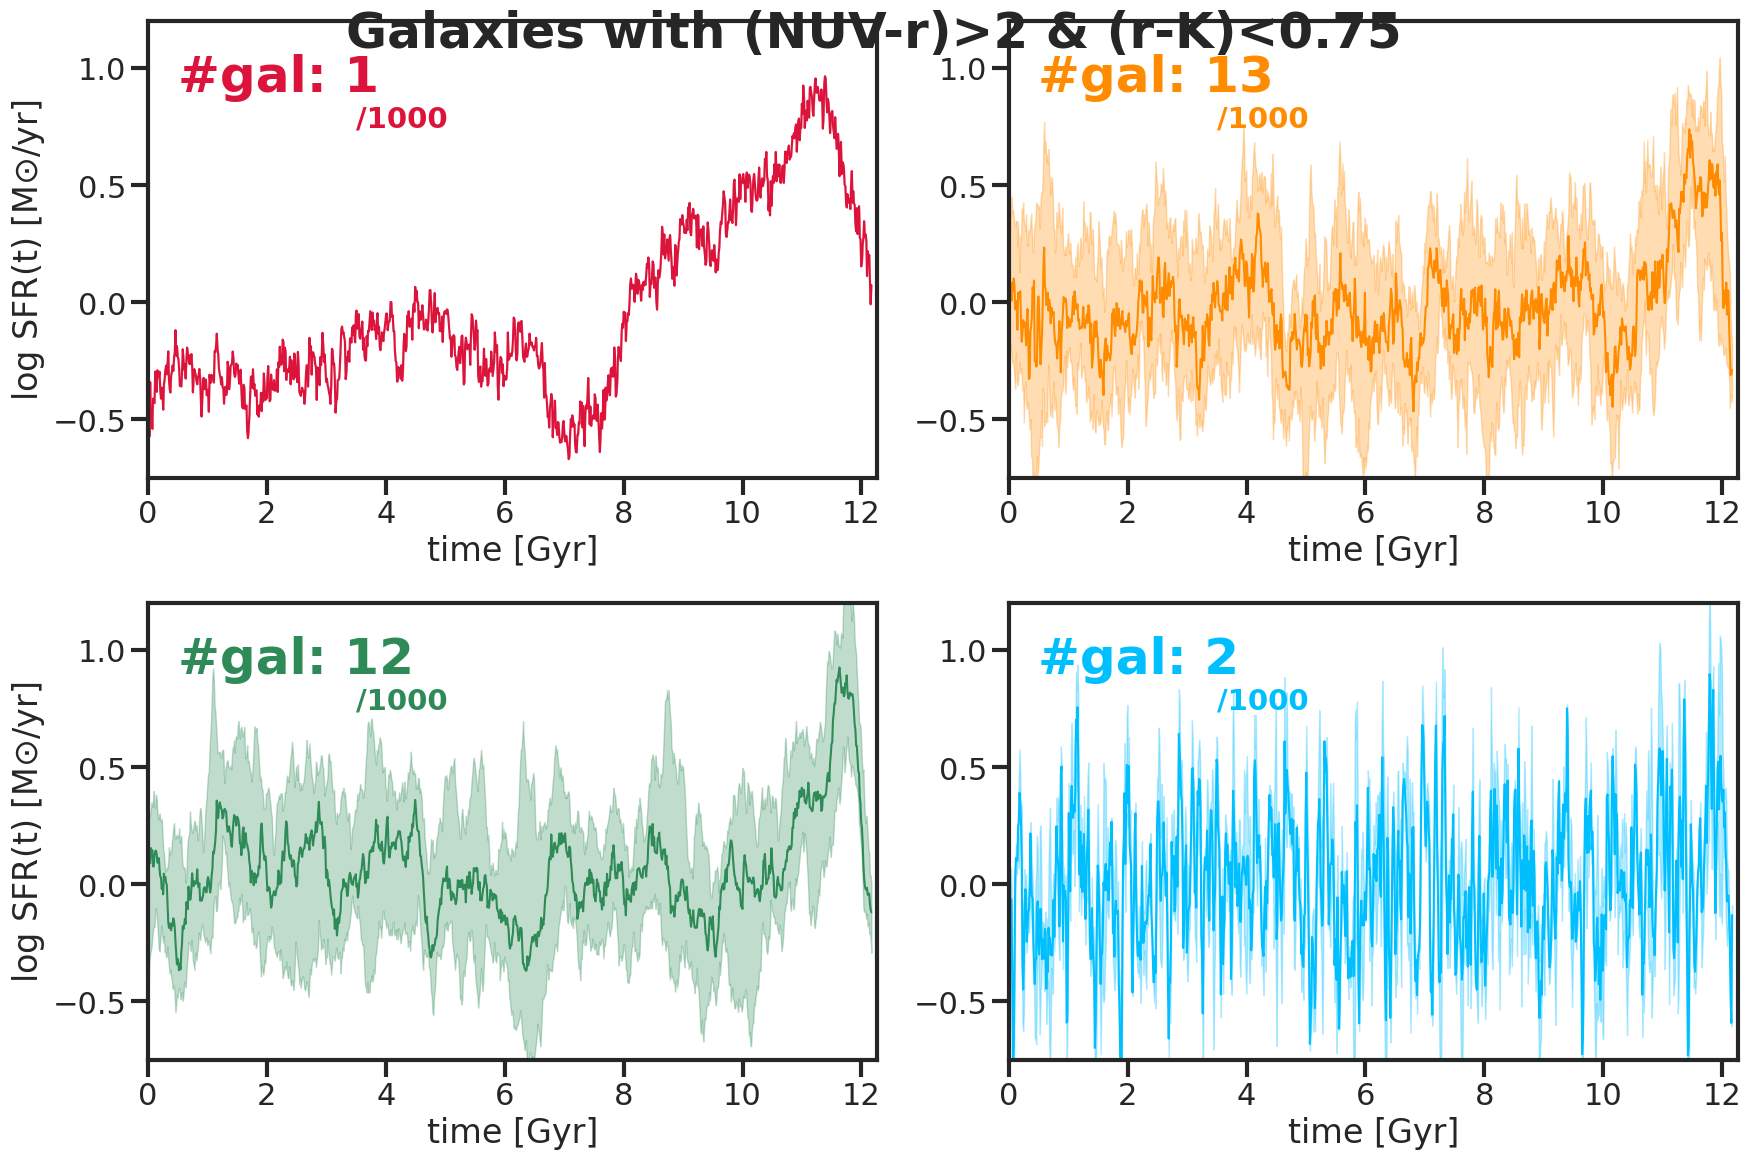

In [37]:
mpl.rcParams.update(mpl.rcParamsDefault)
db.set_plot_style()

nsamp = 1000
tarr_res = 1000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_1dex, kernel_params_dwarf_1dex, kernel_params_noon_1dex, kernel_params_highz_1dex]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

smoothval = 1.0
nbins = 1000
binvals = [np.linspace(10,14,nbins), np.linspace(-3,3,nbins), np.linspace(-6,0,nbins), np.linspace(-10,10,nbins), np.linspace(0.4,1.4,nbins)]

fig = plt.figure(figsize=(9*2,6*2))
fig.suptitle(r'Galaxies with (NUV-r)>2 & (r-K)<0.75', fontsize=36, fontweight='bold')

for i, case in reversed(list(enumerate(cases))):
    
    fname = kernel_dir + 'v3_ExReg_1dex_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.pkl' %(tarr_res, zval, nsamp, random_seed)
    print('opening: ',fname)
    with open(fname, 'rb') as fil:
        case1 = pickle.load(fil)

    band1 = 'galex_nuv'
    band2 = 'sdss_r'
    band3 = '2mass_ks'

    color1_name = band1+' - '+band2
    color2_name = band2+' - '+band3

    color1 = np.array(case1.filtmags)[0:, case1.bands.index(band1)] - np.array(case1.filtmags)[0:, case1.bands.index(band2)]
    color2 = np.array(case1.filtmags)[0:, case1.bands.index(band2)] - np.array(case1.filtmags)[0:, case1.bands.index(band3)]

    mask = (color2 < 0.75) & (color1 > 2)
    print('# galaxies: ',np.sum(mask))

    plt.subplot(2,2,i+1)
#     plt.axhline(0,alpha=0.7, color=case_colors[i])
    plt.plot(case1.tarr, np.nanmedian(case1.samples[mask, 0:],0), color = case_colors[i])
    plt.fill_between(case1.tarr, 
                     np.nanpercentile(case1.samples[mask, 0:],16,0), 
                     np.nanpercentile(case1.samples[mask, 0:],84,0), alpha=0.3, color = case_colors[i])
    plt.xlabel('time [Gyr]'); plt.xlim(0,np.amax(case1.tarr)+0.1)
    if i%2==0:
        plt.ylabel('log SFR(t) [M$\odot$/yr]')
    plt.ylim(-0.75, 1.2)
    plt.text(0.5,0.9,r'#gal: %.0f' %(np.sum(mask)),fontsize=36,fontweight='bold',color=case_colors[i])
    plt.text(3.5,0.75,r'/%.0f' %(len(mask)),fontsize=21,fontweight='bold',color=case_colors[i])
plt.tight_layout()
plt.savefig('figures/colorselectedSFH_v1_'+case+'.png',bbox_inches='tight')
plt.show()

# Figure 11: Validation [varying dust and metallicity]

In [38]:
nsamp = 1000
tarr_res = 1000
zval = 1.0
random_seed = 42

case_params = kernel_params_MW_TCF20

case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
case1.get_tarr(n_tarr = tarr_res)
#case1.get_basesfh(sfhtype='MS', mstar = 10.0)
case1.get_basesfh(sfhtype='dirichlet')
case1.kernel = extended_regulator_model_kernel_paramlist


case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                    force_cov=True, kernel_params = case_params)

tarr = case1.tarr

unknown basesfh type. set yourself with len of tarr.


100%|██████████| 1000/1000 [00:09<00:00, 107.65it/s]


In [39]:
def calc_spectral_features_single(sp, tage):
    
        lam, spectra = sp.get_spectrum(tage = tage)
        emline_wavs = sp.emline_wavelengths
        emline_lum = sp.emline_luminosity

        ha_lambda = 6562 # in angstrom

        ha_line_index = np.argmin(np.abs(emline_wavs - ha_lambda))
        ha_lum = emline_lum[ha_line_index]

        hdelta_mask = (lam > 4041.60) & (lam < 4079.75)
        #hdelta_cont1_flux = np.trapz(x=lam[hdelta_mask], y = spectra[i][hdelta_mask])
        hdelta_cont1_flux = np.mean(spectra[hdelta_mask])
        hdelta_mask = (lam > 4128.50) & (lam < 4161.00)
        #hdelta_cont2_flux = np.trapz(x=lam[hdelta_mask], y = spectra[i][hdelta_mask])
        hdelta_cont2_flux = np.mean(spectra[hdelta_mask])
        hdelta_cont_flux_av = (hdelta_cont1_flux + hdelta_cont2_flux)/2

        hdelta_mask = (lam > 4083) & (lam < 4122)
        #hdelta_emline_flux = np.trapz(x=lam[hdelta_mask], y = spectra[i][hdelta_mask])
        hdelta_emline_fluxes = spectra[hdelta_mask]
        hdelta_emline_fluxratios = hdelta_emline_fluxes / hdelta_cont_flux_av
        hdelta_ew = np.sum(1 - hdelta_emline_fluxratios)

        dn4000_mask = (lam>3850) & (lam < 3950)
        dn4000_flux1 = np.mean(spectra[dn4000_mask])
        dn4000_mask = (lam>4000) & (lam < 4100)
        dn4000_flux2 = np.mean(spectra[dn4000_mask])
        dn4000 = dn4000_flux1/dn4000_flux2
        
        return ha_lum, hdelta_ew, dn4000

In [40]:
tarr = case1.tarr
basesfh = np.ones_like(tarr)

sp.set_tabular_sfh(tarr, basesfh)
lam, spec = sp.get_spectrum(tage = np.amax(tarr))

working at metallicity: -1.5
working at metallicity: -1.4
working at metallicity: -1.3
working at metallicity: -1.2
working at metallicity: -1.1
working at metallicity: -1.0
working at metallicity: -0.9
working at metallicity: -0.8
working at metallicity: -0.7
working at metallicity: -0.6
working at metallicity: -0.5
working at metallicity: -0.4
working at metallicity: -0.3
working at metallicity: -0.2
working at metallicity: -0.1
working at metallicity: 0.0
working at metallicity: 0.1
working at metallicity: 0.2
working at metallicity: 0.3
working at metallicity: 0.4
working at metallicity: 0.5


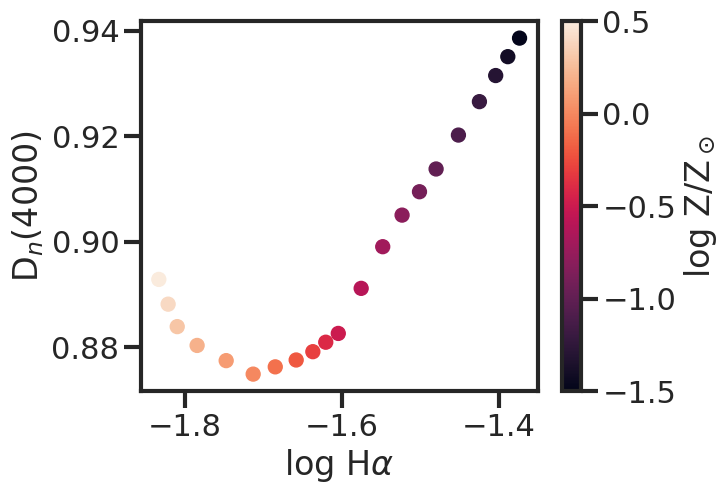

In [41]:
Zvals = np.arange(-1.5, 0.6, 0.1)

masses, sfrs, ha_lums, hd_ews, dn4000s = [], [], [], [], []

for Zi, Z in enumerate(Zvals):
    
    print('working at metallicity: %.1f' %Z)
    sp.params['logzsol'] = Z
    sp.set_tabular_sfh(tarr, basesfh)
    lam, spec = sp.get_spectrum(tage = np.amax(tarr))
    masses.append(np.log10(sp.stellar_mass))
    sfrs.append(np.log10(sp.sfr))
    ha_lum, hd_ew, dn4000 = calc_spectral_features_single(sp, tage = np.amax(tarr))
    ha_lums.append(ha_lum)
    hd_ews.append(hd_ew)
    dn4000s.append(dn4000)
    
plt.scatter(np.log10(ha_lums)-masses, dn4000s,s=100,c=Zvals)
clbr = plt.colorbar()
clbr.set_label('log Z/Z$_\odot$')
plt.xlabel(r'log H$\alpha$')
plt.ylabel('D$_n$(4000)')
plt.savefig('figures/effect_varying_metallicity_zoom.png',bbox_inches='tight')
plt.show()

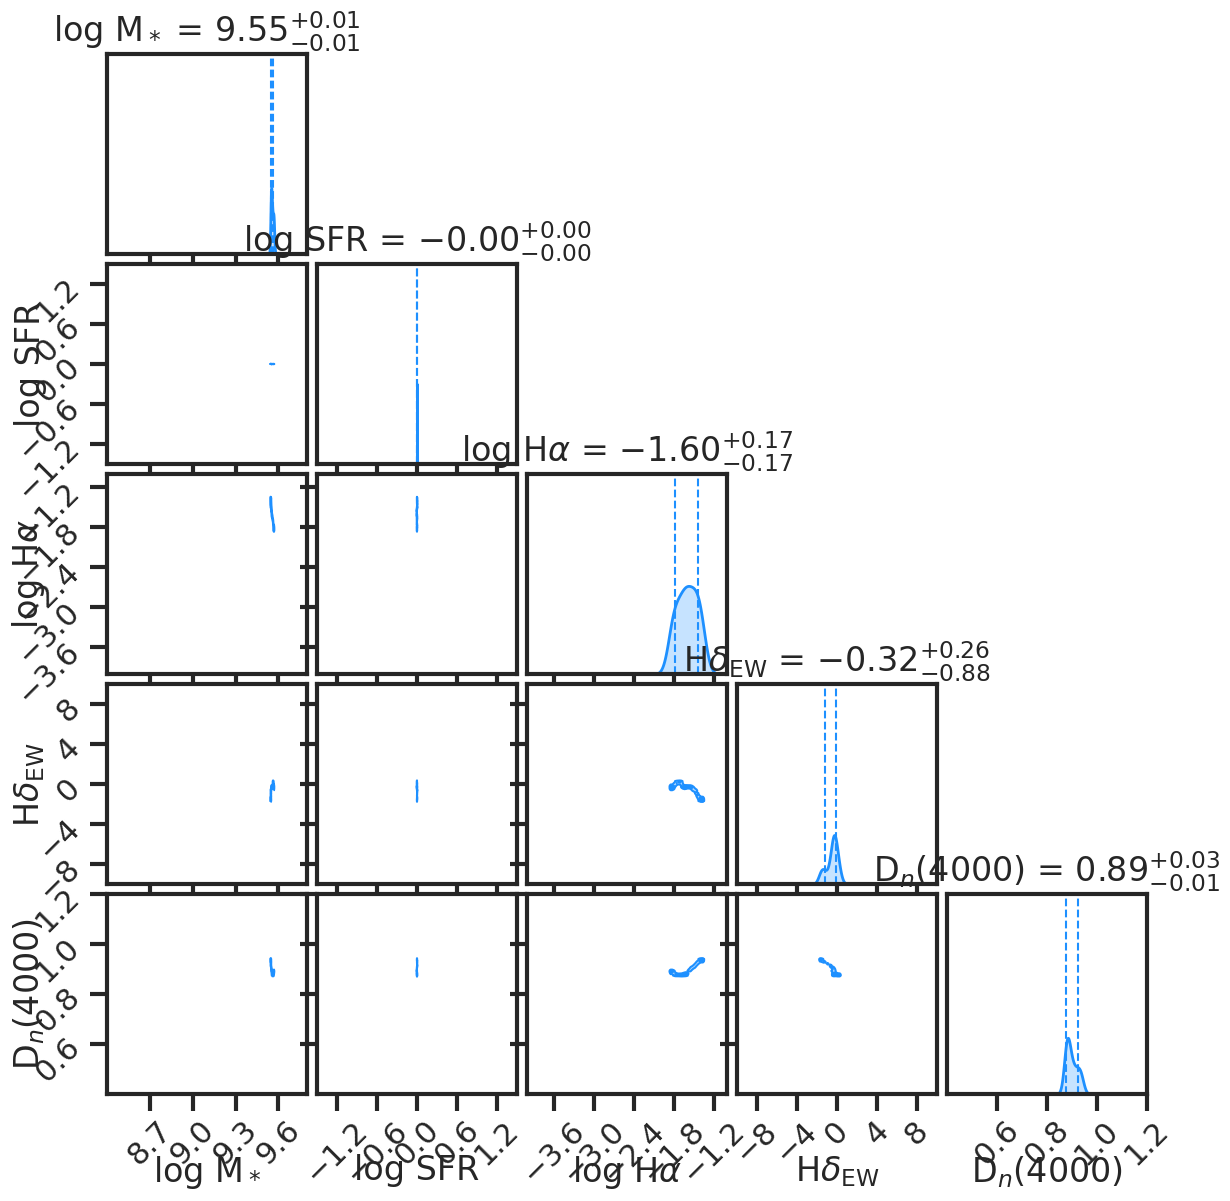

In [42]:
case1_specfeatures = np.vstack((masses, sfrs+np.random.normal(scale=0.001,size=len(sfrs)),
                                np.log10(ha_lums)-masses, hd_ews, dn4000s))

smoothval=1.0
lims = [(8.4,9.8),(-1.5,1.5),(-4,-1),(-10,10),(0.4,1.2)]

fig = corner.corner(case1_specfeatures.T, 
                  labels=['log M$_*$', 'log SFR', r'log H$\alpha$', r'H$\delta_{\rm EW}$', 'D$_n$(4000)'],
                  levels=[1 - np.exp(-(1/1)**2/2),1 - np.exp(-(2/1)**2/2)], quantiles=(0.16,0.84), 
                  plot_datapoints=False, fill_contours=True, smooth=smoothval, show_titles=True,
                  color = 'dodgerblue', hist_kwargs={'lw':0, 'density':True})
axes = np.array(fig.axes).reshape((5,5))
all_specfeatures = case1_specfeatures

for kdei in range(5):
    axkde = axes[kdei, kdei]
    sns.kdeplot(case1_specfeatures[kdei,0:],shade=True,lw=2,color='dodgerblue',ax=axkde)
    axkde.set_ylabel('')

for i in range(5):
    ax = axes[i, i]
    ax.set_xlim(lims[i])
    
    
    for j in range(i):
        ax = axes[i,j]
        ax.set_xlim(lims[j])
        ax.set_ylim(lims[i])

plt.savefig('figures/effect_varying_metallicity.png',bbox_inches='tight')
plt.show()

working at dust: 0.0
working at dust: 0.1
working at dust: 0.2
working at dust: 0.3
working at dust: 0.4
working at dust: 0.5
working at dust: 0.6
working at dust: 0.7
working at dust: 0.8
working at dust: 0.9
working at dust: 1.0
working at dust: 1.1
working at dust: 1.2
working at dust: 1.3
working at dust: 1.4
working at dust: 1.5
working at dust: 1.6
working at dust: 1.7
working at dust: 1.8
working at dust: 1.9
working at dust: 2.0


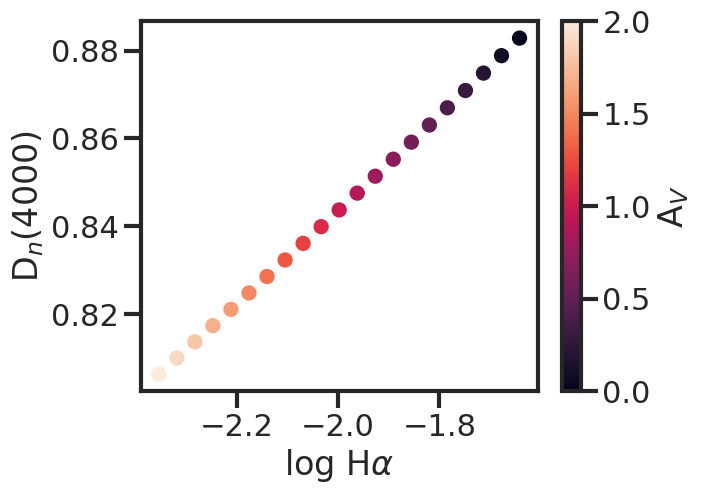

In [43]:
sp.params['logzsol'] = 0.0

dustvals = np.arange(0.0,2.1,0.1)

masses, sfrs, ha_lums, hd_ews, dn4000s = [], [], [], [], []

for Avi, Av in enumerate(dustvals):
    
    print('working at dust: %.1f' %Av)
    
    sp.params['dust2'] = Av
    
    sp.set_tabular_sfh(tarr, basesfh)
    lam, spec = sp.get_spectrum(tage = np.amax(tarr))
    masses.append(np.log10(sp.stellar_mass))
    sfrs.append(np.log10(sp.sfr))
    ha_lum, hd_ew, dn4000 = calc_spectral_features_single(sp, tage = np.amax(tarr))
    ha_lums.append(ha_lum)
    hd_ews.append(hd_ew)
    dn4000s.append(dn4000)
    

plt.scatter(np.log10(ha_lums)-masses, dn4000s,s=100,c=dustvals)
clbr = plt.colorbar()
clbr.set_label('A$_V$')
plt.xlabel(r'log H$\alpha$')
plt.ylabel('D$_n$(4000)')
plt.savefig('figures/effect_varying_dust.png',bbox_inches='tight')
plt.show()

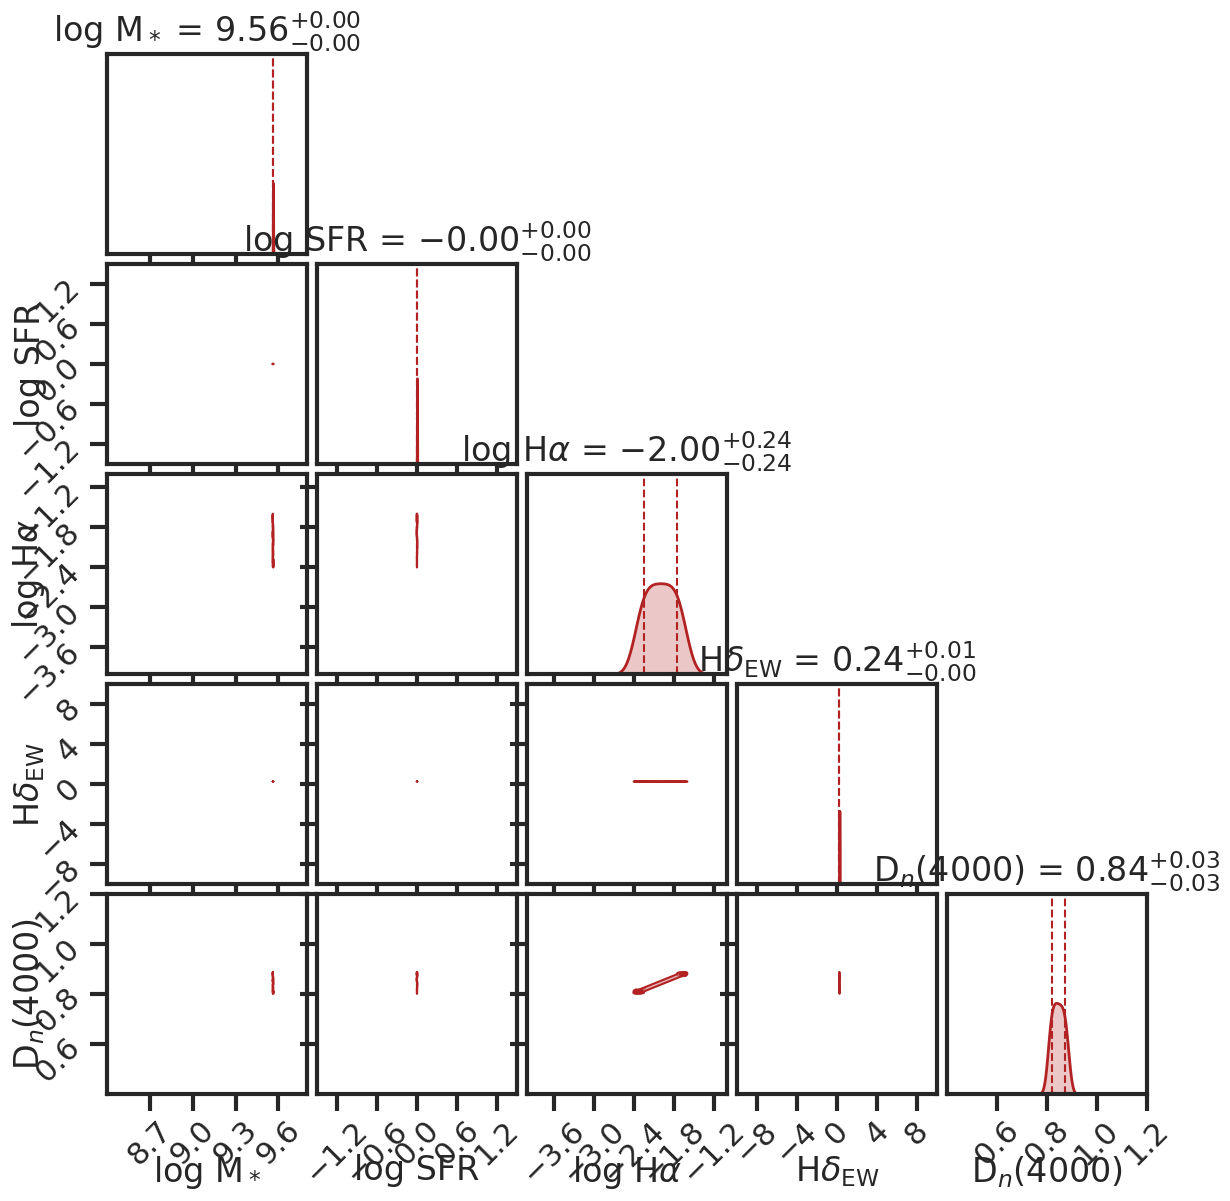

In [44]:
case1_specfeatures = np.vstack((masses+np.random.normal(scale=0.001,size=len(sfrs)), 
                                sfrs+np.random.normal(scale=0.001,size=len(sfrs)),
                                np.log10(ha_lums)-masses, hd_ews, dn4000s))

smoothval=1.0
lims = [(8.4,9.8),(-1.5,1.5),(-4,-1),(-10,10),(0.4,1.2)]

fig = corner.corner(case1_specfeatures.T, 
                  labels=['log M$_*$', 'log SFR', r'log H$\alpha$', r'H$\delta_{\rm EW}$', 'D$_n$(4000)'],
                  levels=[1 - np.exp(-(1/1)**2/2),1 - np.exp(-(2/1)**2/2)], quantiles=(0.16,0.84), 
                  plot_datapoints=False, fill_contours=True, smooth=smoothval, show_titles=True,
                  color = 'firebrick', hist_kwargs={'lw':0, 'density':True})
axes = np.array(fig.axes).reshape((5,5))
all_specfeatures = case1_specfeatures

for kdei in range(5):
    axkde = axes[kdei, kdei]
    sns.kdeplot(case1_specfeatures[kdei,0:],shade=True,lw=2,color='firebrick',ax=axkde)
    axkde.set_ylabel('')

for i in range(5):
    ax = axes[i, i]
    ax.set_xlim(lims[i])
    
    
    for j in range(i):
        ax = axes[i,j]
        ax.set_xlim(lims[j])
        ax.set_ylim(lims[i])
        
plt.savefig('figures/effect_varying_dust_zoom.png',bbox_inches='tight')
plt.show()

# Figure 12: the GP-SFH covariance with binned SFHs

In [45]:
def get_bins(zval, nbins = 10, binspacing='log', minage = 10, printnbin=False):
    """
    Bin an SFH in logarithmically spaced bins
    minage = min age to start log binning in, in Myr
    """
    
    if binspacing == 'log':        
        binedges = np.logspace(np.log10(minage), np.log10(cosmo.age(zval).value*1e3), nbins+1)/1e3
    elif binspacing == 'lin':
        binedges = np.linspace(10**np.log10(minage), 10**np.log10(cosmo.age(zval).value*1e3), nbins+1)/1e3
        
    bincenters = binedges[0:-1] + (binedges[1:] - binedges[0:-1])/2
    
    return bincenters, binedges

bincenters, binedges = get_bins(0.1)
bincenters, binedges

(array([0.01517381, 0.0308751 , 0.06282348, 0.12783084, 0.26010537,
        0.52925257, 1.07690313, 2.19124179, 4.45865598, 9.07230466]),
 array([1.00000000e-02, 2.03476220e-02, 4.14025722e-02, 8.42443890e-02,
        1.71417299e-01, 3.48793440e-01, 7.09711709e-01, 1.44409456e+00,
        2.93838903e+00, 5.97892293e+00, 1.21656864e+01]))

In [46]:
cases = ['MW','dwarf','noon','highz']
case_params = [kernel_params_MW_TCF20, kernel_params_dwarf_TCF20, kernel_params_noon_TCF20, kernel_params_highz_TCF20]

In [47]:
def get_binned_SFH_samples(exreg_params, bincenters, sp = sp, cosmo = cosmo, zval = zval, nsamp = 10000):
    
    kernel_comp = gp_sfh_kernels.extended_regulator_model_kernel_paramlist#(bincenters, exreg_params)
    
    case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
    case1.tarr = bincenters
    case1.get_basesfh(sfhtype='const')
    case1.kernel = kernel_comp

    case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                        force_cov=True, kernel_params = exreg_params)
    
    return case1.covariance_matrix, case1.samples

covmat, samples = get_binned_SFH_samples(case_params[1], bincenters)

100%|██████████| 10/10 [00:00<00:00, 3940.90it/s]


100%|██████████| 10/10 [00:00<00:00, 7230.31it/s]


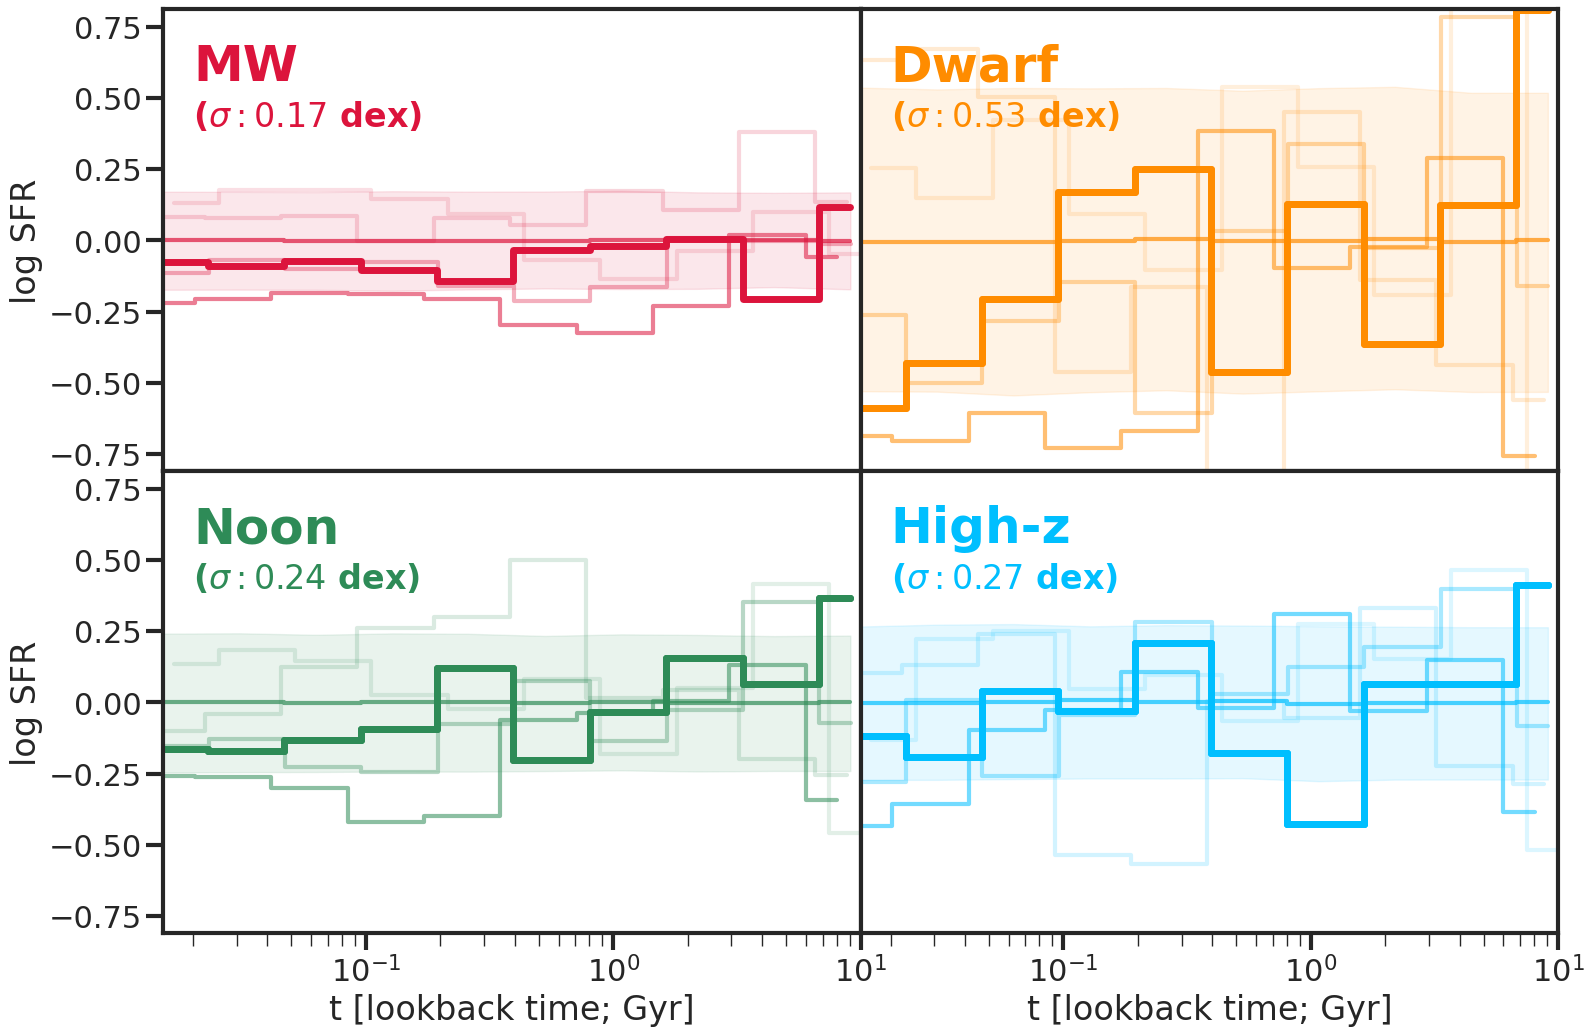

In [48]:
knames = ['MW','Dwarf','Noon','High-z']
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.subplots(2,2,figsize=(9*2,6*2))
plt.subplots_adjust(hspace=0,wspace=0)

for i in range(4):
    covmat, samples = get_binned_SFH_samples(case_params[i], bincenters)

    plt.subplot(2,2,i+1)
    plt.plot(bincenters, np.nanmedian(samples.T,1),'k-',lw=3,alpha=0.7,drawstyle='steps-mid', color=case_colors[i])
    plt.fill_between(bincenters, np.nanpercentile(samples.T,16,1), np.nanpercentile(samples.T,84,1),
                     color=case_colors[i],alpha=0.1)
    for si in range(1,5):
        plt.plot(bincenters*(1+0.1*np.random.normal()), samples.T[0:,si],drawstyle='steps-mid',
                 lw=3,alpha=np.random.uniform()*0.7,color=case_colors[i])
    for k in range(i+1):
        plt.plot(bincenters*1.0, samples.T[0:,0], drawstyle='steps-mid',lw=5, color=case_colors[i])
    plt.xscale('log')
    if (i == 0) or (i==2):
        plt.ylabel('log SFR')
    else:
        plt.yticks([])
    if i > 1:
        plt.xlabel('t [lookback time; Gyr]')
    else:
        plt.xticks([])
    plt.text(2e-2, 1.4*0.4, knames[i], fontsize=36, fontweight='bold',color=case_colors[i])
    plt.text(2e-2, 1.0*0.4, '($\sigma: %.2f$ dex)' %TCF20_scattervals[i], fontsize=24, fontweight='bold',color=case_colors[i])
    plt.xlim(bincenters[0],10.)
    plt.ylim(-0.81,0.81)
plt.savefig('figures/binned_SFH_samples.png')
plt.show()

# Figure 14: a non-stationary kernel

In [49]:
def sigma_fun(t):
    #return 0.6*(-0.01*t**2 + 0.1*t + 1.0)
    return 0.3*(-0.03*t**2 + 0.4*t + 0.0)
    #return 0.3*(-0.03*t**2 + 0.2*t + 0.6*4)

def tau_eq_fun(t):
    return 0.01*t**2+0.01

def timedep_kernel(t, tp, kernel_params, base_e_to_10 = False):
    """
    A basic implementation of the regulator model kernel, with five parameters:
    kernel_params = [sigma, tau_eq, tau_in, sigma_gmc, tau_gmc]
    sigma: \sigma, the amount of overall variance
    tau_eq: equilibrium timescale
    tau_x: inflow correlation timescale (includes 2pi factor)
    sigma_gmc: gmc variability
    tau_l: cloud lifetime

    """

    #sigma, tau_eq, tau_in, sigma_gmc, tau_gmc = kernel_params
    _, _, tau_in, sigma_gmc, tau_gmc = kernel_params

    if base_e_to_10 == True:
        # in TCF20, this is defined in base e, so convert to base 10
        sigma = sigma*np.log10(np.e)
        sigma_gmc = sigma_gmc*np.log10(np.e)

    tau = np.abs(t-tp)

    if tau_in == tau_eq_fun(t):
        c_reg = sigma_fun(t)**2 * (1 + tau/tau_eq_fun(t)) * (np.exp(-tau/tau_eq_fun(t)))
    else:
        c_reg = sigma_fun(t)**2 / (tau_in - tau_eq_fun(t)) * (tau_in*np.exp(-tau/tau_in) - tau_eq_fun(t)*np.exp(-tau/tau_eq_fun(t)))

    c_gmc = sigma_gmc**2 * np.exp(-tau/tau_gmc)

    kernel_val = (c_reg + c_gmc)
    return kernel_val


In [50]:
nsamp = 1000
tarr_res = 1000
zval = 0.1
random_seed = 42

cases = ['MW_timedep']
case_params = [kernel_params_MW_TCF20]

i=0
case = cases[i]

case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
case1.get_tarr(n_tarr = tarr_res)
#case1.get_basesfh(sfhtype='MS', mstar = 10.0)
case1.get_basesfh(sfhtype='const')
case1.kernel = timedep_kernel


case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, stationary=False,
                                    force_cov=True, kernel_params = case_params[i])

# case1.get_spec(nsamp = nsamp)
# case1.calc_spectral_features(massnorm = True)

100%|██████████| 1000/1000 [00:12<00:00, 78.18it/s]


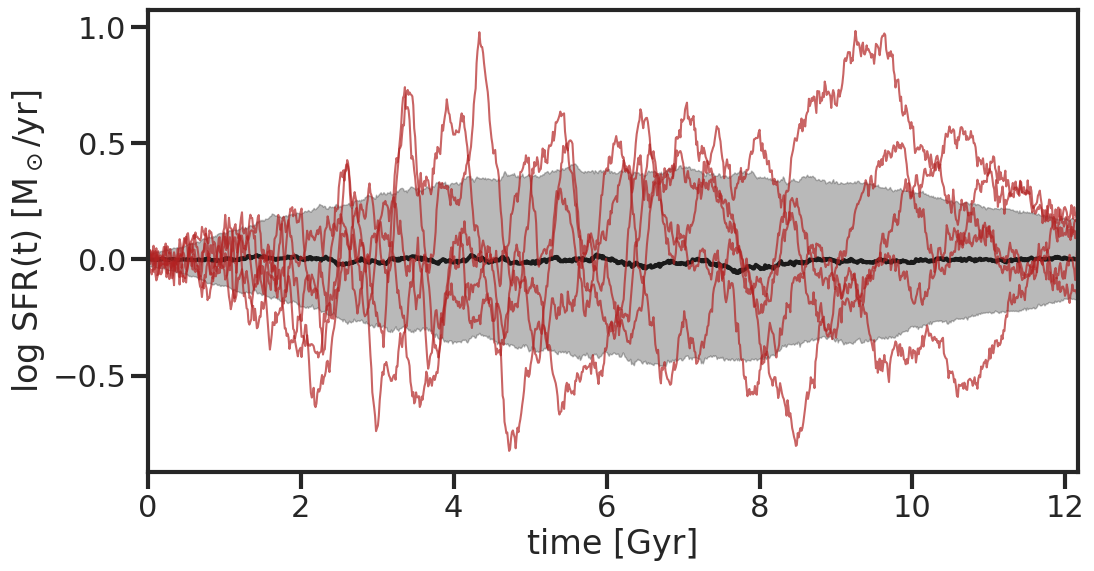

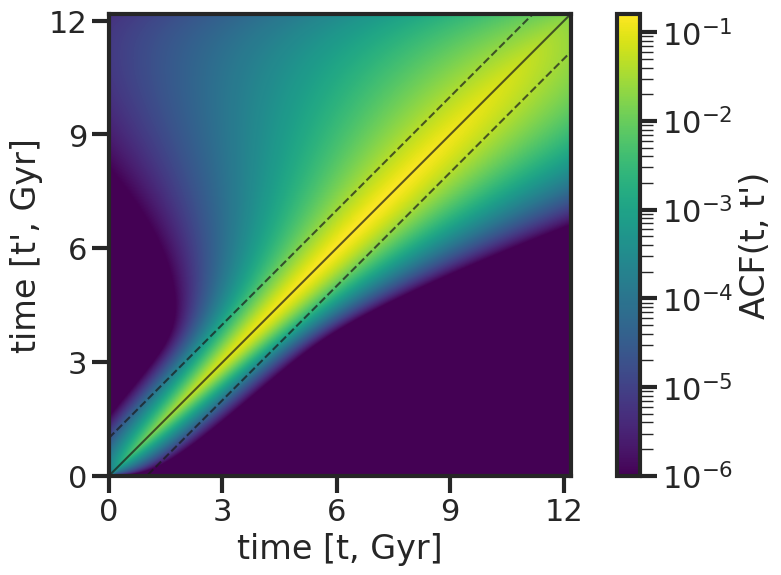

In [51]:
plt.figure(figsize=(12,6))
plt.plot(case1.tarr, np.nanmedian(case1.samples,0),color='k',lw=3)
plt.fill_between(case1.tarr, np.nanpercentile(case1.samples,16,0),
                np.nanpercentile(case1.samples,84,0),alpha=0.3,color='k')

plt.plot(case1.tarr, case1.samples[0:5,0:].T,color='firebrick',alpha=0.7)
plt.xlabel('time [Gyr]')
plt.ylabel('log SFR(t) [M$_\odot$/yr]')
plt.xlim(0,np.amax(case1.tarr))
plt.savefig('figures/nonstationary_kernel.png',bbox_inches='tight')
plt.show()

timevals = [0,3,6,9,12]

pltxticks = [np.argmin(np.abs(case1.tarr - timevals[i])) for i in range(len(timevals))]
pltxticklabels = timevals

index_1gyr = np.argmin(np.abs(case1.tarr - 1.0))
tmep = case1.covariance_matrix.copy()
tmep[tmep<1e-6] = 1e-6

plt.figure(figsize=(12,6))
plt.imshow(tmep, origin='lower',cmap='viridis',norm=matplotlib.colors.LogNorm())
plt.plot([0,len(case1.tarr)],[0,len(case1.tarr)],'k-', alpha=0.7)
plt.plot([0,len(case1.tarr)],[0-index_1gyr,len(case1.tarr)-index_1gyr],'k--', alpha=0.7)
plt.plot([0,len(case1.tarr)],[0+index_1gyr,len(case1.tarr)+index_1gyr],'k--', alpha=0.7)
plt.axis([0,len(case1.tarr),0,len(case1.tarr)])
plt.xticks(pltxticks,pltxticklabels)
plt.yticks(pltxticks,pltxticklabels)
plt.xlabel('time [t, Gyr]');plt.ylabel('time [t\', Gyr]')
clbr = plt.colorbar(); clbr.set_label('ACF(t, t\')')
plt.savefig('figures/timedep_ACF.png',bbox_inches='tight')
plt.show()

# Figure 15: response curves for different spectral features

In [52]:
tages = np.logspace(-3,1,100)
from gp_sfh import calc_spectral_features

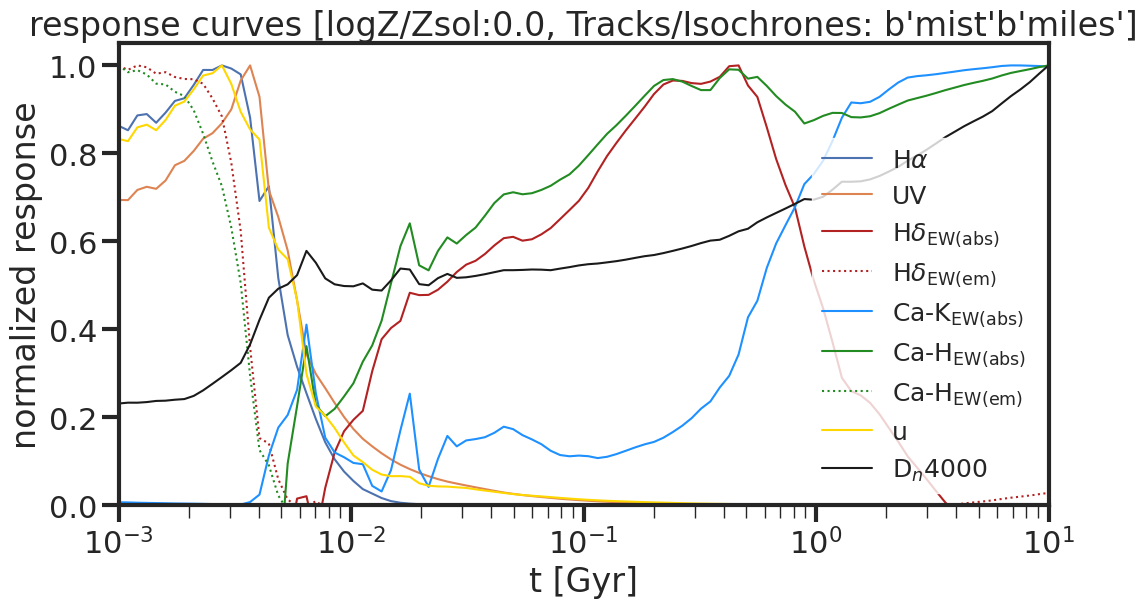

In [53]:
spec_tage = []
massloss = []
emline_lum_tage = []

sp.params['sfh'] = 0
sp.params['logzsol'] = 0.0

for tage in tages:
    lam, tempspec = sp.get_spectrum(tage = tage)
    spec_tage.append(tempspec)
    massloss.append(sp.stellar_mass)
    emline_lum_tage.append(sp.emline_luminosity)
    
emline_wav = sp.emline_wavelengths
    

ha_lums, hdelta_ews, dn4000_vals, fuv_vals, nuv_vals, u_vals, caH_ews, caK_ews  = calc_spectral_features(spec_tage, emline_lum_tage, lam, emline_wav)


plt.figure(figsize=(12,6))
plt.plot(tages, ha_lums/np.amax(ha_lums), label=r'H$\alpha$')
plt.plot(tages, nuv_vals/np.amax(nuv_vals), label=r'UV')
plt.plot(tages, hdelta_ews/np.amax(hdelta_ews), color='firebrick', label=r'H$\delta_{\rm EW (abs)}$')
plt.plot(tages, -np.array(hdelta_ews)/np.amax(-np.array(hdelta_ews)), ':', color='firebrick', label=r'H$\delta_{\rm EW (em)}$')

plt.plot(tages, caK_ews/np.amax(caK_ews), label=r'Ca-K$_{\rm EW (abs)}$',color='dodgerblue')

plt.plot(tages, caH_ews/np.amax(caH_ews), label=r'Ca-H$_{\rm EW (abs)}$',color='forestgreen')
plt.plot(tages, -np.array(caH_ews)/np.amax(-np.array(caH_ews)), ':', color='forestgreen', label=r'Ca-H$_{\rm EW (em)}$')

plt.plot(tages, u_vals/np.amax(u_vals), label=r'u',color='gold')
plt.plot(tages, dn4000_vals/np.amax(dn4000_vals), 'k', label=r'D$_n$4000')
plt.axhline(0,color='k',)
plt.xscale('log')
plt.legend(edgecolor='w',loc=4,fontsize=18)
plt.xlabel('t [Gyr]')
plt.ylim(0,1.05); plt.xlim(1e-3,1e1)
plt.ylabel('normalized response')
plt.title('response curves [logZ/Zsol:%.1f, ' %sp.params['logzsol'] + 'Tracks/Isochrones: '+str(sp.libraries[0])+ str(sp.libraries[1])+']')
plt.savefig('figures/response_curves_solar_met.png',bbox_inches='tight')
plt.show()